# Cognitive, Behavioral and Social Data Project (PHQ9_GAD7)
##### Gaia Ziraldo, Elizaveta German, Bita Darabi


### Introduction

Our project is devoted to malingering detection in questionnaires that are aimed to establish anxiety-depressive disorder. 

Firstly, we shortly describe the questionnaires in which people are faking bad trying to exaggerate anxiety-depression symptoms. Then we are working on classification task in order to distinguish honest responses from dishonest by experimenting with different methods such as logistic regression, decision trees, support vector machines and other. 

After that we are trying to develop malingering remover that allows to reconstruct honest responses from dishonest with the help of denoising autoencoder, multi-output regression and neural network. At the end all models are compared and the best one in terms of accuracy is chosen.


**Mixed anxiety–depressive disorder (MADD)** is the diagnosis defining patients who have both anxiety and depression symptoms such that it influences person’s functioning in daily life, but these symptoms are not severe enough to define a formal diagnosis of either condition.

Depression is defined by such mood-related symptoms as feelings of worthlessness, low self-esteem or low confidence, guilt, helplessness, thoughts of death or suicide, weight changes, often caused by changes in appetite. 

Anxiety is a group of conditions: excessive anxiety, muscle tension and aches, a fast heartbeat and shortness of breath, worry on most days, and difficulty controlling these feelings.

If anxiety and depression symptoms are considered separately, the diagnosis does not seem to be severe, but placed together the effect is strong enough to cause decrease of quality of life.

In our dataset we have responses on two questionnaires: 
The Patient Health Questionnaire (PHQ-9) that consists of 9 questions and is aimed for measuring depression severity, and
Generalized Anxiety Disorder (GAD-7) questionnaire consisting of 7 questions aiming for measuring anxiety. Both questionnaires allow to establish diagnoses and grade its severity. 

The question that was asked for people to answer is: *Over the last 2 weeks, how often have you been bothered by the following problems?*

**The Patient Health Questionnaire (PHQ):**
*   Little interest or pleasure in doing things
*   Feeling down, depressed or hopeless
*   Trouble falling or staying asleep, or sleeping too much
*   Feeling tired or having little energy
*   Poor appetite or overeating
*   Feeling bad about yourself
*   Trouble concentrating on things
*   Moving or speaking so slowly that over people could have noticed OR being so fidgety or restless that you have been moving around a lot more than usual
*   Thoughts that you would be better off dead or of hurting yourself in some way

**Generalized Anxiety Disorder (GAD):**

*   Feeling nervous, anxious or on edge
*   Not being able to stop or control worrying
*   Worrying too much about different things
*   Trouble relaxing
*   Being so restless that it is hard to sit still
*   Becoming easily annoyed or irritable
*   Feeling afraid as if something awful might happen

The people were asked to answer these questions on the Likert scale from 1 to 5, where 1 is less often, and 5 is very often. So faking bad responses are expected to be higher than the honest.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold, StratifiedKFold, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.svm import LinearSVR, SVC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

## Data preparation

Our dataset consists of 559 honest and 559 dishonest responses. At the beginning we prepare data for the analysis by splitting it into train, validation and test sets.


In [2]:
# load the dataset and consider only the (H) and (D) responses
#path = '/content/drive/MyDrive/CBS/PHQ9_GAD7_df.csv'
path = '/content/drive/MyDrive/CBS/PHQ9_GAD7_df.csv'
# path = "PHQ9_GAD7_df.csv" # path for Gaia
data = pd.read_csv(path, sep=";")

# removing clinical participants
data = data[data.CONDITION != "P"]

In [3]:
# split the dataset in train, validation and test
# for the classification model we include both honest and dishonest responses
# in equal measure in all sets
data.index[data.CONDITION == "H"]

y = data.CONDITION # class to be predicted - honest or dishonest
X = data.iloc[:,:-1] # all variables

y_h = y[y == "H"]
X_h = X[y == "H"]

y_d = y[y == "D"]
X_d = X[y == "D"]

Xh_train, Xh_test, yh_train, yh_test = train_test_split(X_h, y_h, test_size=0.2, random_state=1)
Xh_train, Xh_val, yh_train, yh_val  = train_test_split(Xh_train, yh_train, test_size=0.25, random_state=1)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(X_d, y_d, test_size=0.2, random_state=1)
Xd_train, Xd_val, yd_train, yd_val  = train_test_split(Xd_train, yd_train, test_size=0.25, random_state=1)

# let's merge the honest/dishonest sets
X_train = Xh_train.append(Xd_train)
X_val = Xh_val.append(Xd_val)
X_test = Xh_test.append(Xd_test)

y_train = yh_train.append(yd_train)
y_val = yh_val.append(yd_val)
y_test = yh_test.append(yd_test)

In [4]:
# check to make sure the sets are well built and evenly distributed

print(str(sum(y_train == "H"))+" + "+str(sum(y_train == "D")))
print(str(sum(y_val == "H"))+" + "+str(sum(y_val == "D")))
print(str(sum(y_test == "H"))+" + "+str(sum(y_test == "D")))

335 + 335
112 + 112
112 + 112


## Explorary Data Analysis

### Distribution of honest and fake responses

The graph below shows that the mean of dishonest responses in all questions is much higher than for the honest responses. The mean honest responses are below 3, while the mean dishonest responses all are above 4.

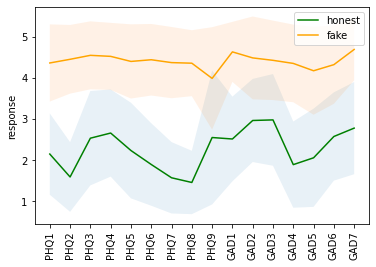

In [6]:
plt.plot(X_h.columns, X_h.mean(), color = 'green', label = 'honest')
plt.plot(X_d.columns, X_d.mean(), color = 'orange', label = 'fake')
plt.fill_between(range(16), X_h.mean()-X_h.std(), X_h.mean()+X_h.std(),alpha=.1)
plt.fill_between(range(16), X_d.mean()-X_d.std(), X_d.mean()+X_d.std(),alpha=.1)
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
#plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

#from google.colab import files
#plt.savefig('resp_graph.png')
#files.download('resp_graph.png')

In [7]:
X_hh = np.array(X_h)
X_dd = np.array(X_d)
first_100h = X_hh[:100]
first_100d = X_dd[:100]

Here we analysed how faking bad strategy changed the honest responses. 86% of all responses were changed in expected direction, so the dishonest response is higher than the honest one. 9% of responses remained the same, and only 5% changed unexpectedly, so dishonest response is lower than the honest.

In [8]:
# all cases
print(round(np.sum(X_hh == X_dd) / (X_hh.shape[0] * X_hh.shape[1]), 2)) # did not change
print(round(np.sum(X_hh < X_dd) / (X_hh.shape[0] * X_hh.shape[1]), 2)) # changed in expected direction
print(round(np.sum(X_hh > X_dd) / (X_hh.shape[0] * X_hh.shape[1]), 2)) # changed in unexpected direction

0.09
0.86
0.05


For 100 out of 559 responses: 89% changed in expected direction, 7% remained the same, and 4% changed unexpectedly.

In [9]:
# 100 out of 559 cases
print(round(np.sum(first_100h == first_100d) / (first_100d.shape[0] * first_100d.shape[1]), 2)) # did not change
print(round(np.sum(first_100h < first_100d) / (first_100h.shape[0] * first_100h.shape[1]), 2)) # changed in expected direction
print(round(np.sum(first_100h > first_100d) / (first_100h.shape[0] * first_100h.shape[1]), 2)) # changed in unexpected direction

0.07
0.89
0.04


### Correlation matrices

By the analysis of correlation matrices for both honest and dishonest responses it can be seen that correlation between questions in the honest condition is higher, on average, than in the dishonest condition. That can be explained that in dishonest condition people are trying to exaggerate everything, so they answer each question with the high grade. That makes difficult to find any meaningful correlation between questions. 

For honest responses we can highlight that questions PHQ1, PHQ4 and GAD4 are correlated (the correlation coefficient is above 0,4). All these three questions(little interest or pleasure in doing things, feeling tired, trouble relaxing) describe more or less the same condition. If people cannot relax, they cannot enjoy the process at the moment. Questions GAD4 and GAD7 are also correlated with coefficient equal to 0,42 - trouble relaxing and feeling afraid that something awful can happen. 

#### Honest responses

In [ ]:
honestcorr = X_h.corr()
honestcorr

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
PHQ1,1.000000,0.241591,0.023061,0.427657,0.128568,-0.126406,0.128729,0.060849,0.057045,0.109215,0.148823,0.236784,0.469554,-0.316795,0.231333,0.383847
PHQ2,0.241591,1.000000,0.196334,0.186896,0.123560,0.261276,0.219114,0.165802,0.003347,0.373254,0.223114,0.261410,0.284634,0.076034,0.307252,0.225163
PHQ3,0.023061,0.196334,1.000000,0.116356,0.284132,0.319445,0.207534,0.213239,0.098037,0.359868,0.261440,0.232371,0.103819,0.309921,0.217649,0.087082
PHQ4,0.427657,0.186896,0.116356,1.000000,0.188809,0.004361,0.149841,0.183811,0.092524,0.066143,0.127539,0.254354,0.310393,-0.224591,0.174578,0.283489
PHQ5,0.128568,0.123560,0.284132,0.188809,1.000000,0.170346,0.252615,0.209956,0.120056,0.218932,0.161299,0.204273,0.141724,0.113744,0.284794,0.208112
PHQ6,-0.126406,0.261276,0.319445,0.004361,0.170346,1.000000,0.149961,0.249512,0.044684,0.334845,0.270774,0.200431,-0.025663,0.430084,0.143334,0.082651
PHQ7,0.128729,0.219114,0.207534,0.149841,0.252615,0.149961,1.000000,0.188500,0.069061,0.205714,0.190466,0.265814,0.234179,0.085574,0.296696,0.228152
PHQ8,0.060849,0.165802,0.213239,0.183811,0.209956,0.249512,0.188500,1.000000,0.177356,0.174504,0.153583,0.237720,0.094802,0.151354,0.231512,0.189827
PHQ9,0.057045,0.003347,0.098037,0.092524,0.120056,0.044684,0.069061,0.177356,1.000000,0.047431,0.036953,0.032139,0.094194,-0.009953,0.039830,0.099621
GAD1,0.109215,0.373254,0.359868,0.066143,0.218932,0.334845,0.205714,0.174504,0.047431,1.000000,0.355855,0.317648,0.282456,0.306957,0.375505,0.199964


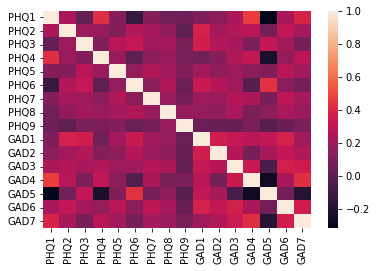

In [ ]:
%matplotlib inline
sns.heatmap(honestcorr)

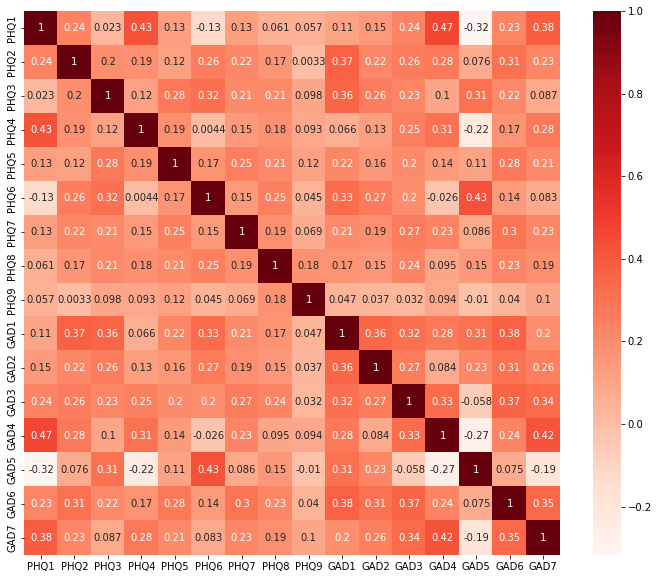

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(honestcorr, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Dishonest responses

In [ ]:
fakecorr = X_d.corr()
fakecorr

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
PHQ1,1.000000,0.305297,0.164477,0.330610,0.182252,0.201516,0.213516,0.182946,0.206218,0.238528,0.219417,0.179261,0.334939,0.071789,0.170534,0.312212
PHQ2,0.305297,1.000000,0.287387,0.316071,0.311583,0.302664,0.406530,0.208788,0.267327,0.477426,0.269430,0.320352,0.402367,0.233602,0.333127,0.298227
PHQ3,0.164477,0.287387,1.000000,0.321422,0.313488,0.246747,0.310960,0.142975,0.110003,0.339883,0.243916,0.283407,0.173245,0.263757,0.315465,0.214374
PHQ4,0.330610,0.316071,0.321422,1.000000,0.297660,0.250788,0.318537,0.147771,0.199330,0.242235,0.273178,0.264797,0.310262,0.032526,0.252142,0.286451
PHQ5,0.182252,0.311583,0.313488,0.297660,1.000000,0.334090,0.368687,0.226054,0.249860,0.285270,0.215989,0.354463,0.154684,0.245728,0.398181,0.315419
PHQ6,0.201516,0.302664,0.246747,0.250788,0.334090,1.000000,0.284108,0.236590,0.264697,0.255076,0.164631,0.202423,0.203812,0.222360,0.222560,0.210301
PHQ7,0.213516,0.406530,0.310960,0.318537,0.368687,0.284108,1.000000,0.250095,0.246628,0.328504,0.230616,0.292000,0.302152,0.348041,0.386868,0.334145
PHQ8,0.182946,0.208788,0.142975,0.147771,0.226054,0.236590,0.250095,1.000000,0.164283,0.168880,0.122806,0.171189,0.175039,0.328855,0.241525,0.196923
PHQ9,0.206218,0.267327,0.110003,0.199330,0.249860,0.264697,0.246628,0.164283,1.000000,0.192776,0.226362,0.165411,0.233651,0.113254,0.163550,0.227709
GAD1,0.238528,0.477426,0.339883,0.242235,0.285270,0.255076,0.328504,0.168880,0.192776,1.000000,0.230631,0.336208,0.329795,0.252805,0.331515,0.351885


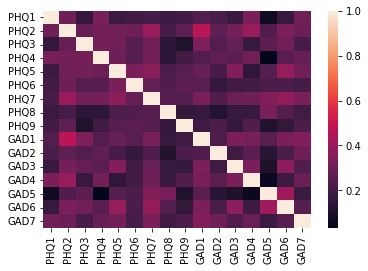

In [ ]:
%matplotlib inline
sns.heatmap(fakecorr)

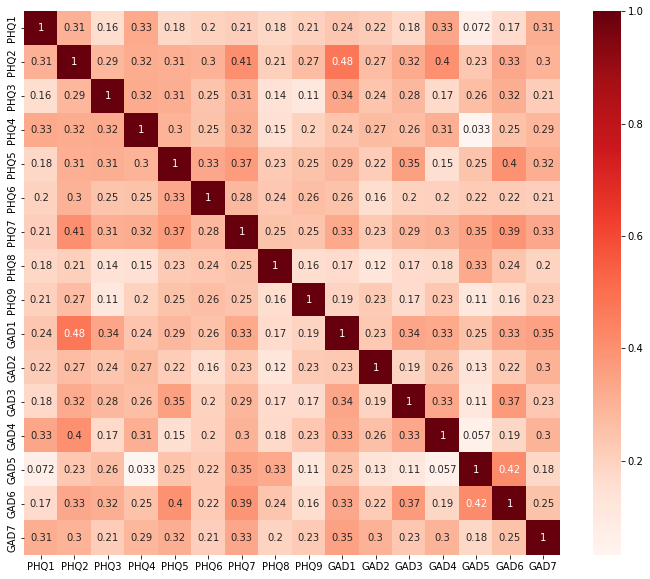

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(fakecorr, annot=True, cmap=plt.cm.Reds)
plt.show()

## Classification
The first task we considered consisted in building a classification model able to distinguish between a questionnaire compiled honestly and a faked one.
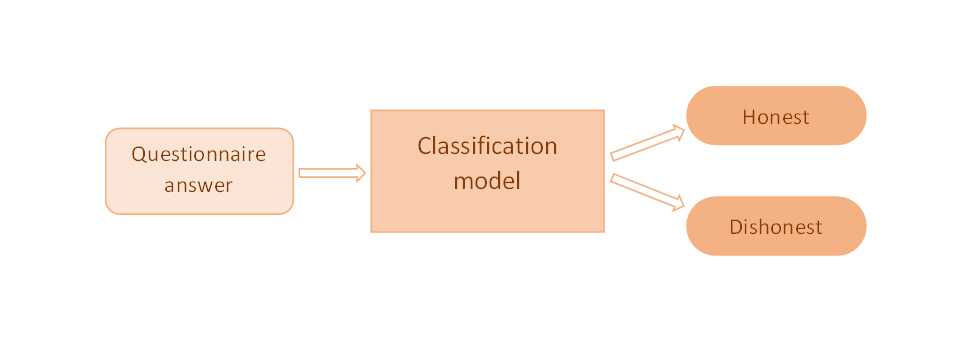
Given the moderate size of the dataset (559 observations per class) it appeared necessary to use 10-fold cross validation to obtain an unbiased estimate for the errors of the models. Since the dataset was already balanced with respect to the class variable, no undersampling was necessary.


### Logistic Regression

The first classification model we implemented is Logistic Regression, which models the probability of an outcome by applying the following nonlinear function:

\begin{equation}
σ(\beta^{T} x) = \frac{1}{1+e^{-\beta^{T} x}}
\end{equation}

Such function is called *sigmoid* and outputs values between 0 and 1, which in our case corresponds to the probability of a questionnaire being answered honestly.
In our experiments this simple method achieved a satisfactory test accuracy, while providing interpretable results obtained by analyzing the coefficients.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)
y_test_pred = lr.predict(X_test)

print(f"Logistic Regression.\tTrain ACC: {accuracy_score(y_train, y_train_pred)}")
print(f"Logistic Regression.\tVal ACC: {accuracy_score(y_val, y_val_pred)}")
print(f"Logistic Regression.\tTest ACC: {accuracy_score(y_test, y_test_pred)}")

Logistic Regression.	Train ACC: 0.9940298507462687
Logistic Regression.	Val ACC: 0.9866071428571429
Logistic Regression.	Test ACC: 0.9821428571428571


The plot below shows the values of the fitted coefficients $\beta$. Given that the questionnaire data are strictly positive, a positive coefficient leads to the sigmoid assuming a value closer to 1, while negative coefficients encourage the sigmoid towards 0. Hence, we can interpret positive values of $\beta$ as the ones able to predict honest answers, while negative values indicate items able to identify dishonest subjects.

Questions associated with honest predictions:
*   GAD3: Worrying too much about different things;
*   GAD7: Feeling afraid as if something awful might happen;

Questions associated with dishonest predictions:
*   PHQ1: Little interest or pleasure in doing things;
*   PHQ2: Feeling down, depressed or hopeless;
*   PHQ8: Moving or speaking so slowly that over people could have noticed OR being so fidgety or restless that you have been moving around a lot more than usual.



Feature: 0, Score: -1.13479
Feature: 1, Score: -1.18878
Feature: 2, Score: -0.57747
Feature: 3, Score: 0.01549
Feature: 4, Score: -0.27028
Feature: 5, Score: -0.53912
Feature: 6, Score: -0.75370
Feature: 7, Score: -1.82645
Feature: 8, Score: 0.20209
Feature: 9, Score: -0.24801
Feature: 10, Score: 0.14774
Feature: 11, Score: 0.92990
Feature: 12, Score: -0.67853
Feature: 13, Score: -0.20119
Feature: 14, Score: -0.02397
Feature: 15, Score: 0.54373


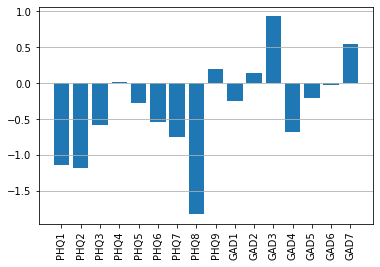

In [12]:
# The positive scores indicate a feature that predicts class 1, 
# whereas the negative scores indicate a feature that predicts class 0

importance = lr.coef_[0]

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.grid(axis='y')
plt.show()

We implemented K-fold Cross-validation in order to obtain reliable accuracy scores.

In [13]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(lr, X, y, scoring='accuracy', cv=kf, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.985 (0.008)


In [14]:
from sklearn.model_selection import RepeatedKFold

kf = RepeatedKFold(n_splits=10, n_repeats = 5, random_state=42) 
scores = cross_val_score(lr, X, y, scoring='accuracy', cv=kf, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.986 (0.011)


### Random Forest

A random forest is an estimator that fits several decision tree classifiers and averages their responses. This ensemble method is less interpretable and acts more as a blackbox classifier, however we mostly tested it in order to obtain the feature importances.

As can be seen in the plot below, the items which achieved the highest importance score (thus resulting more discriminating between the two classes during the decsion process) were the following:


*   PHQ2: Feeling down, depressed or hopeless;
*   PHQ7: Trouble concentrating on things;
*   PHQ8: Moving or speaking so slowly that over people could have noticed OR being so fidgety or restless that you have been moving around a lot more than usual.

It's possible to observe that two of these questions (PHQ2 and PHQ8) achieved a high importance also according to the logistic regression classifier. One possible reason of this occurrence is the high average difference between honest and dishonest responses in these two specific items, as can be observed in the plot in the Exploratory Data Analysis section.



Feature: 0, Score: 0.10871
Feature: 1, Score: 0.17109
Feature: 2, Score: 0.01672
Feature: 3, Score: 0.00798
Feature: 4, Score: 0.02243
Feature: 5, Score: 0.09814
Feature: 6, Score: 0.14407
Feature: 7, Score: 0.20900
Feature: 8, Score: 0.00458
Feature: 9, Score: 0.08738
Feature: 10, Score: 0.00834
Feature: 11, Score: 0.00450
Feature: 12, Score: 0.03438
Feature: 13, Score: 0.01224
Feature: 14, Score: 0.00537
Feature: 15, Score: 0.06508


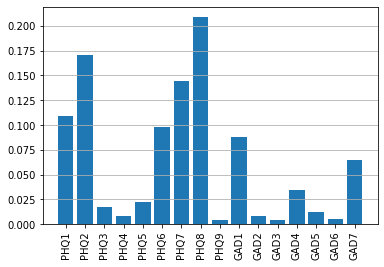

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

# get importance
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.grid(axis='y')
plt.show()

In [16]:
# 10-fold cross validation
X = X_train.append(X_val)
y = y_train.append(y_val)

forest = RandomForestClassifier(random_state=0, criterion="entropy")
cv = cross_validate(forest, X, y, cv=10, return_estimator=True)

# print the accuracies of each fold and their mean
temp = []
for i in range(10):
  temp.append(cv['estimator'][i].score(X_test, y_test))

print(temp)
print(sum(temp)/10)

[0.9866071428571429, 0.9910714285714286, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9866071428571429, 0.9866071428571429, 0.9866071428571429, 0.9866071428571429, 0.9821428571428571]
0.9870535714285715


### XGBoost

XGBoost or Extreme Gradient Boosting is an ensemble method based on Decision Trees.

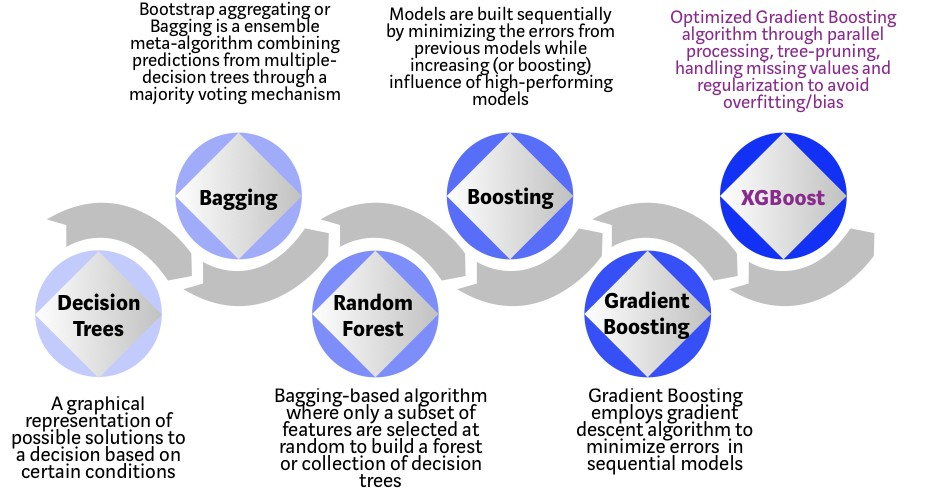
As shown in the picture it combines training different classifiers on different sets, Bootstrap Aggregating and Gradient Boosting and reptresents a powerful classification tool, able to avoid overfitting. It's worth noting that this method achieved one of the highest accuracies on the test set.

Similarly to the Random Forest Classifier, XGBoost is a blackbox tool and trades off higher performances with less interpretability. However it was possible to retrieve the feature importances for this method and, similarly to the previous two classifiers, the items that resulted more relevant were the following:
*   PHQ1: Little interest or pleasure in doing things;
*   PHQ2: Feeling down, depressed or hopeless;
*   PHQ8: Moving or speaking so slowly that over people could have noticed OR being so fidgety or restless that you have been moving around a lot more than usual.


In [17]:
#!pip install xgboost

In [18]:
y = data.CONDITION 
X = data.iloc[:,:-1]

Feature: 0, Score: 0.08904
Feature: 1, Score: 0.18634
Feature: 2, Score: 0.01316
Feature: 3, Score: 0.02862
Feature: 4, Score: 0.00585
Feature: 5, Score: 0.04703
Feature: 6, Score: 0.04982
Feature: 7, Score: 0.45475
Feature: 8, Score: 0.00425
Feature: 9, Score: 0.01674
Feature: 10, Score: 0.01081
Feature: 11, Score: 0.00837
Feature: 12, Score: 0.03177
Feature: 13, Score: 0.01156
Feature: 14, Score: 0.00438
Feature: 15, Score: 0.03752


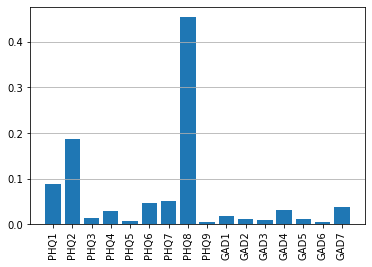

In [19]:
import xgboost
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X, y)

# get importance
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.grid(axis='y')
plt.show()

In [20]:
# 10-fold cross validation
X = X_train.append(X_val)
y = y_train.append(y_val)

xgb = XGBClassifier()
cv = cross_validate(xgb, X, y, cv=10, return_estimator=True)

# print the accuracies of each fold and their mean
temp = []
for i in range(10):
  temp.append(cv['estimator'][i].score(X_test, y_test))

print(temp)
print(sum(temp)/10)

[0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9866071428571429]
0.9879464285714287


### Decision Tree

Decision Trees are non-parametric nonlinear models that exploit a binary tree structure to partition the feature space and to generate a decision rule associated with the path from the root node to a leaf.

A Decision Tree is built by restricting one dimension at a time at every node, and splitting the training dataset into subsets constituting the successor children. The criterion controlling on which dimensions to perform the splits is based on maximizing the information gain.

Out of all the models implemented, the Decision Tree achieved one of the lowest accuracies on the test set (96.7% which is still a satisfactory result) but is the most interpretable method given its structure.

In [23]:
# Preparing data for 10-fold cross validation
X = X_train.append(X_val)
y = y_train.append(y_val)

In [24]:
# compile a decision tree classifier with entropy decision criterion
tree = DecisionTreeClassifier(random_state=0, criterion="entropy")
cv = cross_validate(tree, X, y, cv=10, return_estimator=True)

# print the accuracies of each fold and their mean
temp = []
for i in range(10):
  temp.append(cv['estimator'][i].score(X_test, y_test))

print(temp)
print(sum(temp)/10)

[0.96875, 0.9642857142857143, 0.9821428571428571, 0.9642857142857143, 0.9776785714285714, 0.9553571428571429, 0.9776785714285714, 0.96875, 0.9508928571428571, 0.9598214285714286]
0.9669642857142857


In [25]:
# select one of the 10 folds to provide a visualization
skf = StratifiedKFold(n_splits=10)
for train_index, val_index in skf.split(X,y):
    X_train1, X_val1 = X.iloc[train_index], X.iloc[val_index] 
    y_train1, y_val1 = y.iloc[train_index], y.iloc[val_index]

tree.fit(X_train1, y_train1)
tree.predict(X_test)
tree.score(X_test, y_test)

0.9598214285714286

As can be seen below

It's possible to observe that at most 6 questions are required for the decision tree to discriminate between an honest or a dishonest answer to the PHQ_GAD test.

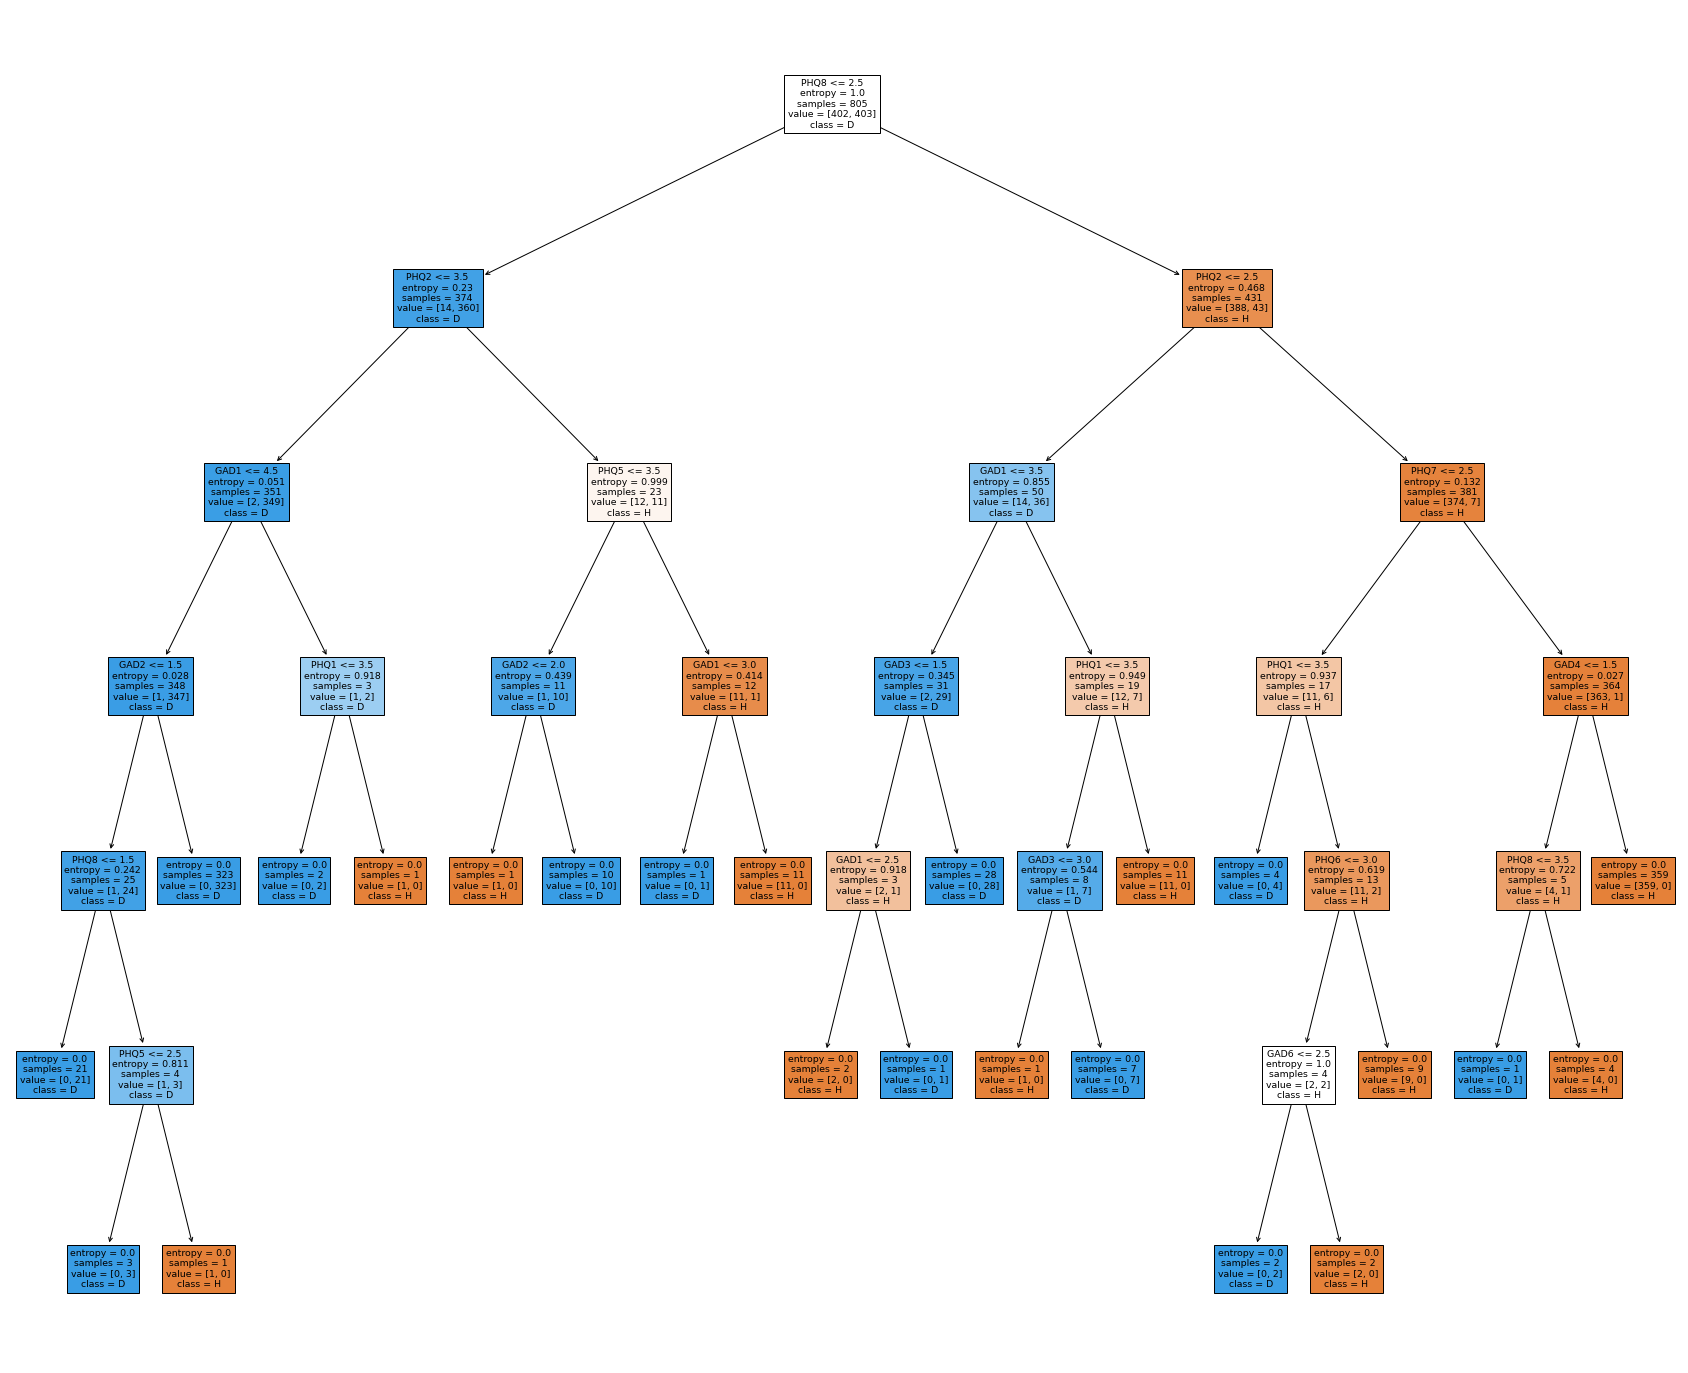

The depth of the decision tree classifier is: 6


In [26]:
# visualize the decision tree
plt.figure(figsize=[30,25])
plot = plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=['H','D'])
plt.show()
print("The depth of the decision tree classifier is: " + str(tree.get_depth()))

In line with the previously tested methods, PHQ2 and PHQ8 resulted the most important items for the classification. This can also be noticed in the tree structure, since PHQ8 corresponds to the root node, while PHQ2 is the node immediately after it, in both splits.

To further confirm this statement, we fitted a decision tree of maximum depth of 2, having PHQ2 and PHQ2 as root and internal nodes. This reduced tree achieved an accuracy of 94.6%, quite similar to the accuracy of the original tree while being a much simpler model.

Feature: 0, Score: 0.03021
Feature: 1, Score: 0.19142
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.02039
Feature: 5, Score: 0.00503
Feature: 6, Score: 0.03043
Feature: 7, Score: 0.65023
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.03342
Feature: 10, Score: 0.01076
Feature: 11, Score: 0.01527
Feature: 12, Score: 0.00787
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00497
Feature: 15, Score: 0.00000


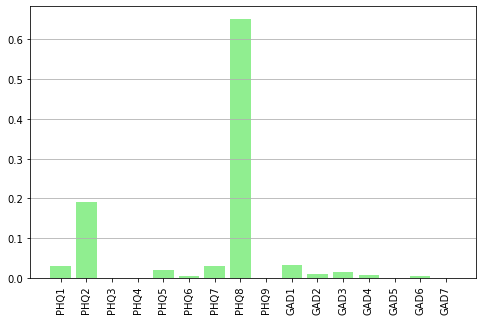

In [ ]:
# get importance
importance = tree.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

fig, ax = plt.subplots(figsize=(8,5))
plt.bar([x for x in range(len(importance))], importance, color='lightgreen')
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.grid(axis='y')
plt.show()

In [31]:
# fit a decision tree of depth 2
tree3 = DecisionTreeClassifier(random_state=0, criterion="entropy", max_depth=2)
tree3.fit(X_train1, y_train1)
tree3.predict(X_test)
tree3.score(X_test, y_test)

0.9464285714285714

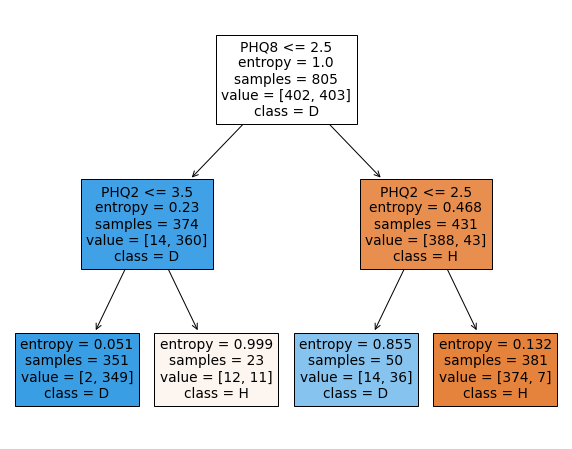

In [32]:
# visualize the reduced decision tree
plt.figure(figsize=[10,8])
plot = plot_tree(tree3, filled=True, feature_names=X_train.columns, class_names=['H','D'])
plt.show()

### Deep Neural Network

Next, we fitted a multilayer perceptron with *relu* activation functions for the hidden layers and *sigmoid* activation for the output layer in order to obtain a binary response. The purpose of this method was to test if processing the data through nonlinear functions could improve the performance of a simple Logistic Regression classifier.

Below is illustrated the structure of the model, which counted a total of 926 trainable parameters, against the 17 parameters (16+intercept) of the Logistic classifier.

The Neural Network however performed slightly worse than the first model we tried, achieving a test accuracy of 97.99%, even though Lasso regularization was implemented to avoid overfitting.

In [ ]:
# one hot encoding function for the response variable
def onehot(ydata):
  enc = OneHotEncoder()
  resp = np.array(ydata).reshape(-1, 1)
  return enc.fit_transform(resp).toarray()

In [ ]:
# deep neural network for classification

network = keras.models.Sequential([
    tf.keras.Input(shape=(16,)),
    keras.layers.Dense(22, activation="relu"),
    keras.layers.Dense(22, activation="relu"),
    keras.layers.Dense(2, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l1(0.004))
])

network.summary()

network.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 22)                374       
                                                                 
 dense_1 (Dense)             (None, 22)                506       
                                                                 
 dense_2 (Dense)             (None, 2)                 46        
                                                                 
Total params: 926
Trainable params: 926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 10-fold cross validation
scores = []
skf = StratifiedKFold(n_splits=10)
for train_index, val_index in skf.split(X,y):
    X_train1, X_val1 = X.iloc[train_index], X.iloc[val_index] 
    y_train1, y_val1 = y.iloc[train_index], y.iloc[val_index]

    history = network.fit(X_train1, onehot(y_train1), epochs=50,
                    validation_data=(X_val1, onehot(y_val1)))
    
    scores.append(network.evaluate(X_test, onehot(y_test), verbose=2))

print(np.array(scores)[:,1])
print(np.sum(np.array(scores)[:,1])/10)

Epoch 1/50
26/26 [==============================] - 1s 10ms/step - loss: 0.5574 - accuracy: 0.7388 - val_loss: 0.3149 - val_accuracy: 0.9222
Epoch 2/50
26/26 [==============================] - 0s 3ms/step - loss: 0.2180 - accuracy: 0.9527 - val_loss: 0.1567 - val_accuracy: 0.9444
Epoch 3/50
26/26 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.9689 - val_loss: 0.1499 - val_accuracy: 0.9556
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 0.1156 - accuracy: 0.9751 - val_loss: 0.1695 - val_accuracy: 0.9111
Epoch 5/50
26/26 [==============================] - 0s 3ms/step - loss: 0.1158 - accuracy: 0.9701 - val_loss: 0.1839 - val_accuracy: 0.9111
Epoch 6/50
26/26 [==============================] - 0s 3ms/step - loss: 0.0947 - accuracy: 0.9764 - val_loss: 0.1688 - val_accuracy: 0.9222
Epoch 7/50
26/26 [==============================] - 0s 3ms/step - loss: 0.1074 - accuracy: 0.9726 - val_loss: 0.1367 - val_accuracy: 0.9667
Epoch 8/50
26/26 [=

### Support Vector Machine

A Support Vector Classifier is a model that fits an hyperplane (or decision boundary) having the largest minimum distance from any of the training samples. Such hyperplane is defined by the samples that lie nearest to it, which are called *support vectors*.

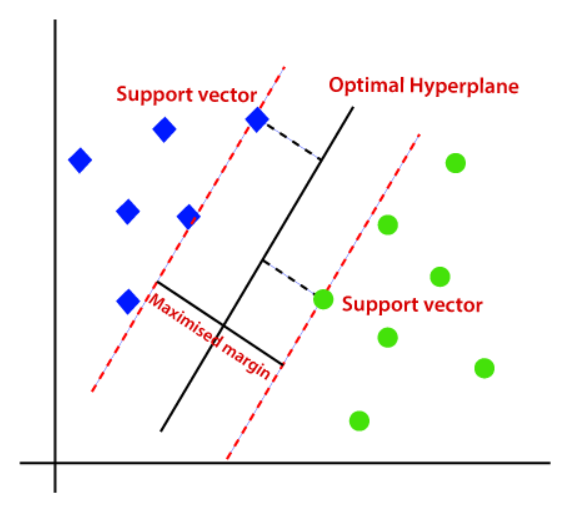

As in the previous models, 10-fold cross-validation has been used to ensure unbiased error estimates.

In [ ]:
supp = SVC(kernel='linear', random_state=1)
cv = cross_validate(supp, X, y, cv=10, return_estimator=True)

In [ ]:
temp = []
for i in range(10):
  temp.append(cv['estimator'][i].score(X_test, y_test))

print(cv['test_score'])
print('Mean validation accuracy = %', sum(cv['test_score'])/10)

print(temp)
print('Mean test accuracy = %', sum(temp)/10)

[0.98888889 0.97777778 1.         0.98888889 0.97752809 0.98876404
 1.         0.97752809 0.98876404 1.        ]
Mean validation accuracy = % 0.9888139825218477
[0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9776785714285714, 0.9821428571428571, 0.9821428571428571, 0.9866071428571429]
Mean test accuracy = % 0.9816964285714285


In the following plot we wanted to visualize a small number of support vectors, which in this case coincided with subjects whose answers resulted difficult to classify. As can be seen in the image, these subjects either alternated between extreme scores on the Likert scale, or assigned the same average score to all the items.

The average of all the support vectors can be seen in the subsequent plot.

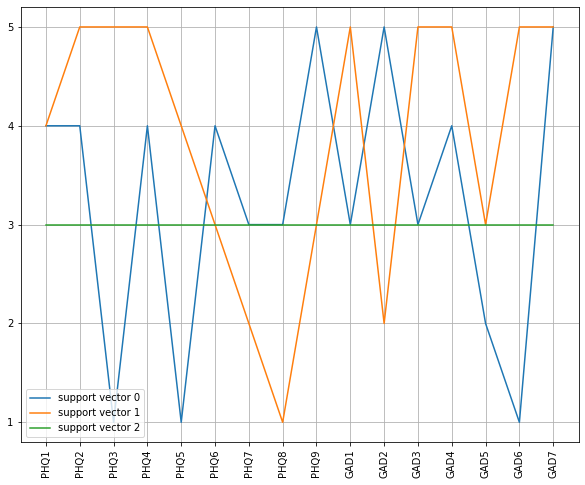

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
for i in range(3):
  plt.plot(cv['estimator'][0].support_vectors_[i], label='support vector '+str(i))

plt.yticks([1, 2, 3, 4, 5])
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.legend()
plt.grid()
plt.show()

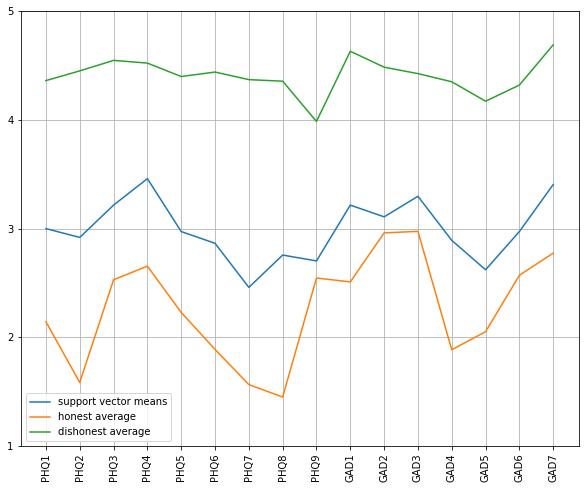

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(cv['estimator'][0].support_vectors_.mean(axis=0), label='support vector means')

plt.plot(X_h.mean(), label='honest average')
plt.plot(X_d.mean(), label='dishonest average')
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.shape(cv['estimator'][0].support_vectors_)

(29, 16)

### k-Nearest Neighbours

The model that achieved the highest test accuracy among all the classifiers was K-Nearest Neighbours. This simple but powerful non-parametric classification method, given a sample, considers the k nearest observations to it and assigns it the class of the majority of the neighbours.

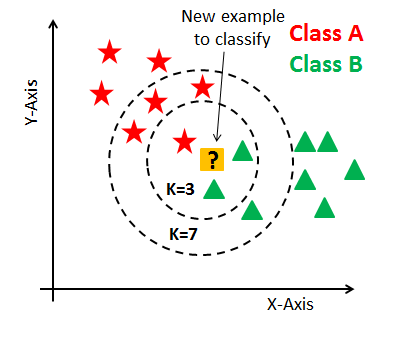

Since the number k of neighbours taken into account has a high influence on the prediction, the best value for this parameter has been chosen with 10-fold cross-validation. The range tested was from 1 to 10 and the best number resulted to be k=4 neighbours.

In [ ]:
# train a k-NN classifier using 10-fold cross validation
knn = KNeighborsClassifier(n_neighbors=3)
cv = cross_validate(knn, X, y, cv=10, return_estimator=True)

# print the accuracies of each fold and their mean
temp = []
for i in range(10):
  temp.append(cv['estimator'][i].score(X_test, y_test))

print(cv['test_score'])
print('Mean validation accuracy = %', sum(cv['test_score'])/10)

print(temp)
print('Mean test accuracy = %', sum(temp)/10)

[0.98888889 0.97777778 0.98888889 1.         0.94382022 0.98876404
 1.         0.98876404 0.98876404 0.96629213]
Mean validation accuracy = % 0.9831960049937578
[0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9866071428571429, 0.9776785714285714, 0.9866071428571429, 0.9910714285714286, 0.9866071428571429, 0.9866071428571429, 0.9866071428571429]
Mean test accuracy = % 0.9861607142857144


In [ ]:
# determine the best number of neighbors k with grid search
knn = KNeighborsClassifier()
parameters = {'n_neighbors':list(range(1,10))}
grid = GridSearchCV(knn, param_grid=parameters, cv=10, refit=True)
grid.fit(X, y)

print(grid.best_estimator_)
best_knn = grid.best_estimator_

print(grid.score(X_test, y_test))

KNeighborsClassifier(n_neighbors=4)
0.9910714285714286


### K-means

K-means was the last non-parametric model we considered. It's a cluster-detection algorithm which, given in advance the number of groups, assigns each observation to the cluster with closest mean (or *centroid*) as can be seen in the picture below.

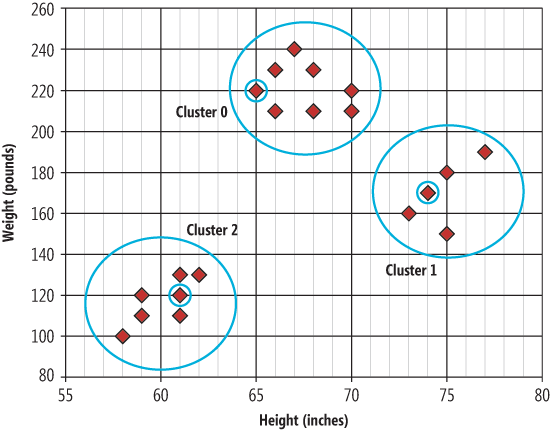

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
pred = pd.DataFrame(kmeans.predict(X_test))


pred[pred==0]='H'
pred[pred==1]='D'
pred = pred.values[:,0]
sum(y_test.values == pred)/len(pred)



0.9866071428571429

An interesting observation can be made on the two centroids for the honest cluster and the dishonest one. As can be seen in the plot below the centroids highly resemble the average response for the corresponding class. This derives trivially from the definition of centroid, and the slight discrepancy between the lines is explained by the fact that the two centroids were computed on the training set instead of the whole dataset

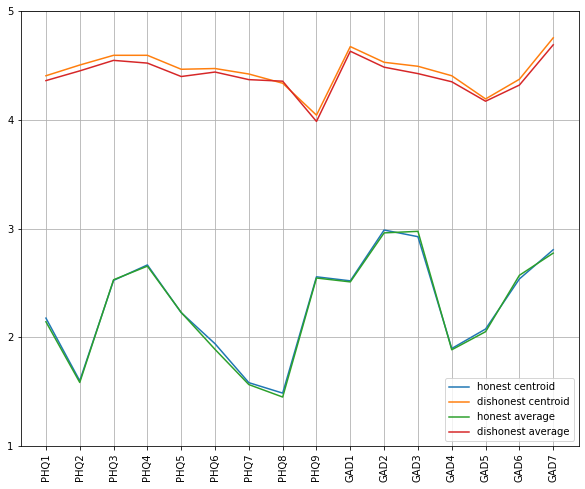

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(kmeans.cluster_centers_[0], label='honest centroid')
plt.plot(kmeans.cluster_centers_[1], label='dishonest centroid')

plt.plot(X_h.mean(), label='honest average')
plt.plot(X_d.mean(), label='dishonest average')
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.legend()
plt.grid()
plt.show()


### Model comparison

The following table reports all the test accuracies of every trained model in decreasing order. It's worth noting that all the methods performed well, with relatively low misclassification errors. This is probably due to the fact that the considered dataset showed on average a high difference in the answers of honest and dishonest subjects, for every item in the questionnaire.

In [56]:
pd.DataFrame(['0.9910', '0.9879', '0.9870', '0.9866', '0.9860', '0.9816', '0.9799', '0.9598'],
             index = ['K-Nearest Neighbours', 'XGBoost', 'Random Forest', 'K-means', 'Logistic Regression',
               'Support Vector Machine', 'Multilayer Perceptron', 'Decision Tree'],
             columns = ['Test accuracy'])

,Test accuracy
K-Nearest Neighbours,0.9910
XGBoost,0.9879
Random Forest,0.9870
K-means,0.9866
Logistic Regression,0.9860
Support Vector Machine,0.9816
Multilayer Perceptron,0.9799
Decision Tree,0.9598


## TF-IDF for classification

In order to try a different aproach to the problem, we developed a classifier based on the TF-IDF index. TF-IDF stands for *Term Frequency - Inverse Document Frequency* and measures the degree of anomaly of a response given the context. The index is computed in the following way:

\begin{equation}
\DeclareMathOperator{\tfidf}{TF-IDF}
\DeclareMathOperator{\tf}{TF}
\DeclareMathOperator{\idf}{IDF}
\tf(value, subject) = \text{N. of times the response} \textit{ value } \text{is used by the subject}
\end{equation}

\begin{equation}
\DeclareMathOperator{\tfidf}{TF-IDF}
\DeclareMathOperator{\tf}{TF}
\DeclareMathOperator{\idf}{IDF}
\idf(value, item) = \log\Bigl(\frac{\text{N. of participants}}{\text{N. of times the response} \textit{ value } \text{is used for the current item}}\Bigr)
\end{equation}

\begin{equation}
\DeclareMathOperator{\tfidf}{TF-IDF}
\DeclareMathOperator{\tf}{TF}
\DeclareMathOperator{\idf}{IDF}
\tfidf(value, subject, item) = \tf(value, subject) * \idf(value, item)
\end{equation}

Since this index has high values for responses to single items which are highly atypical, it can be used to identify faked responses at single item level when its value is higher than a certain threshold. The optimal level of such threshold can be obtained by testing the classifier on a validation set.

We respectively built two classifiers:

*   Global classifier: identifies faked answers at subject level
*   Single question classifier: identifies faked answers at single item level for each subject

The first method operates at subject level by averaging the TF-IDF score for every item and checking its value against an appropriate threshold, while the second computes a threshold for every item in order to identify which item has been faked.

### Global classifier

In [33]:
y = data.CONDITION
X = data.iloc[:,:-1]

In [34]:
def tf_idf_matrix(dataframe):
  """
  Parameters:
  dataframe: the dataframe taken into consideration

  Output:
  tf_matrix*idf_matrix: TF-IDF scores of all subject/responses
  """

  tf_matrix = np.zeros(dataframe.shape)
  idf_matrix = np.zeros(dataframe.shape)

  for subject in range(dataframe.shape[0]):
    for item in range(dataframe.shape[1]):
      value = dataframe.iloc[subject,item]
      tf_matrix[subject, item] = sum(dataframe.iloc[subject,:] == value)
      idf_matrix[subject, item] = np.log10(X_h.iloc[:,item].shape[0]/(sum(X_h.iloc[:,item] == value)))
  
  
  return tf_matrix*idf_matrix

In [35]:
X_ti = pd.DataFrame(tf_idf_matrix(X), columns=X.columns, index=X.index)
X_ti

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
0,2.273739,1.092476,3.184110,1.734178,2.253733,1.756062,4.577931,0.815403,6.940759,3.296650,1.838440,4.165864,4.342149,4.780677,2.217149,4.208986
1,0.951140,1.092476,4.040051,3.034812,2.253733,1.756062,6.887887,0.815403,1.388667,3.784102,3.217271,3.919238,1.240614,1.678961,3.880010,2.512100
2,5.115914,3.645196,3.359347,3.901901,0.860921,7.455003,3.923941,4.075356,5.949222,4.865273,3.607703,5.039020,7.138524,6.425892,4.988585,4.472926
3,1.902281,2.430131,4.308168,0.867089,2.308600,7.075261,0.798548,9.101777,5.033561,1.883800,3.325723,3.163822,1.226011,1.343168,3.042560,0.993984
4,2.853421,3.645196,4.275578,3.462901,2.582763,2.485001,4.339145,4.075356,2.516780,1.621758,3.607703,3.469042,2.379508,0.335792,4.476418,3.607703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,25.104370,30.034925,19.952695,19.399576,1.721842,24.463765,30.034925,38.463765,9.720667,25.104370,18.892605,16.188861,30.034925,2.062817,20.889950,17.584702
1114,8.173397,10.999244,9.976348,5.518593,6.026448,8.254471,0.653990,10.618740,4.860334,12.552185,9.446303,8.094430,15.017463,7.219859,0.554287,8.792351
1115,16.138524,19.308166,5.026196,12.471156,13.429254,8.254471,10.124673,10.618740,5.872488,16.138524,12.145246,10.407125,19.308166,7.219859,5.142022,11.304451
1116,10.508654,14.141885,7.125963,6.928420,7.748290,10.612891,0.983984,13.652666,0.991537,8.965846,4.988585,4.745733,10.726759,9.282676,6.611171,6.280251


In [36]:
# TF-IDF statistics for honest subjects
X_ti.iloc[:559,:].describe()

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,3.122902,2.450546,3.391291,3.157418,3.324479,2.954119,2.384008,2.065222,2.728181,3.396112,3.103483,3.219920,3.061937,2.927040,3.424811,3.270667
std,1.505651,1.840798,1.641518,1.888182,1.343782,1.726511,2.023377,2.026878,1.977944,1.959307,2.597607,2.451612,1.564913,1.652403,2.017033,1.898401
min,0.475570,0.218495,0.559891,0.433545,0.450747,0.351212,0.199637,0.326161,0.346011,0.470950,0.459610,0.527304,0.306503,0.335792,0.480240,0.496992
25%,2.027450,1.310971,2.239564,1.734178,2.308600,1.756062,1.197823,0.896943,1.384045,2.162344,1.662862,1.679673,1.860921,1.678961,1.920960,1.987967
50%,2.853421,1.822598,3.184110,2.771368,3.377649,2.460697,1.597097,1.304645,2.422079,2.825700,2.405135,2.636519,2.758525,2.698944,2.881440,2.981951
75%,3.979044,3.037664,4.457755,3.941852,4.056720,3.512125,2.951951,2.446209,3.460113,4.391615,3.607703,3.691126,3.965846,3.693713,4.407447,4.064567
max,9.341026,15.713205,9.552331,11.825556,8.952836,11.792101,13.017436,12.135703,11.990685,11.146357,16.559387,14.759757,9.518032,10.314085,11.409601,12.193700


In [37]:
# TF-IDF statistics for dishonest subjects
X_ti.iloc[559:,:].describe()

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,14.926262,19.573412,12.878277,12.040871,12.803093,15.154533,18.406221,21.180907,6.034952,16.405634,11.785514,9.816761,17.327837,10.509703,12.094921,11.952910
std,9.322119,10.538736,6.974364,6.971249,7.675673,8.827494,11.030417,14.967863,3.591767,8.814273,6.953576,5.972718,11.659188,7.399702,8.130191,5.726251
min,0.475570,0.218495,0.559891,0.433545,0.450747,0.351212,0.199637,0.163081,0.346011,0.470950,0.459610,0.527304,0.306503,0.335792,0.480240,0.496992
25%,5.838141,10.999244,6.462252,5.542736,6.026448,7.075261,8.581407,7.584814,2.997671,8.269543,4.988585,4.218430,6.042295,3.226073,4.407447,7.193891
50%,14.345354,20.427167,12.826733,12.471156,13.429254,15.726706,19.308166,16.686592,5.995343,17.931693,12.145246,10.407125,17.162815,10.314085,11.937114,12.560501
75%,23.311201,30.034925,19.952695,18.013892,19.397811,22.716354,27.889574,35.716354,9.720667,25.104370,18.217869,15.032514,27.889574,17.543133,19.397811,17.584702
max,28.690709,34.325629,22.803080,22.170944,23.874229,27.958589,34.325629,43.958589,15.987580,28.690709,21.591549,18.501555,34.325629,21.591549,23.874229,20.096802


In [38]:
def tf_idf_subject(subject):
  """
  Parameters:
  subject: the subject considered

  Output:
  tf_matrix*idf_matrix: TF-IDF scores of all subject/responses
  """

  tf_matrix = np.zeros(len(subject))
  idf_matrix = np.zeros(len(subject))

  for item in range(len(subject)):
    value = subject.iloc[item]
    tf_matrix[item] = sum(subject == value)
    idf_matrix[item] = np.log10(X_h.iloc[:,item].shape[0]/(sum(X_h.iloc[:,item] == value)))
  
  
  return tf_matrix*idf_matrix

In [39]:
# define a TF-IDF classifier according to a threshold value
def tfidf_classifier(data, thresh):

  y_pred = []

  for subj in range(data.shape[0]):
    tfidf = tf_idf_subject(data.iloc[subj,:]).mean() # average the tf-idf score of every question

    if tfidf > thresh:
      y_pred.append('D')
    else: y_pred.append('H')

  return pd.DataFrame(y_pred);

In [40]:
# extract the TF-IDF quantiles for the honest subjects
quantiles = []
for i in range(50,100):
  quantiles.append(X_ti.iloc[:559,:].mean(axis=1).quantile(i/100)) 

In [41]:
# compute the validation accuracies of the classifier on every threshold defined by a quantile
val_accuracies = []
for i, thr in enumerate(quantiles):
  pred = tfidf_classifier(X_val, thr).values[:,0]
  actual = y_val.values
  val_accuracies.append([(i+50)/100, sum(pred == actual)/len(pred)])

val_accuracies

[[0.5, 0.7544642857142857],
 [0.51, 0.7544642857142857],
 [0.52, 0.7589285714285714],
 [0.53, 0.7678571428571429],
 [0.54, 0.7678571428571429],
 [0.55, 0.7767857142857143],
 [0.56, 0.7857142857142857],
 [0.57, 0.7946428571428571],
 [0.58, 0.7991071428571429],
 [0.59, 0.8035714285714286],
 [0.6, 0.8080357142857143],
 [0.61, 0.8080357142857143],
 [0.62, 0.8035714285714286],
 [0.63, 0.8080357142857143],
 [0.64, 0.8169642857142857],
 [0.65, 0.8169642857142857],
 [0.66, 0.8214285714285714],
 [0.67, 0.8258928571428571],
 [0.68, 0.8348214285714286],
 [0.69, 0.84375],
 [0.7, 0.84375],
 [0.71, 0.8482142857142857],
 [0.72, 0.8482142857142857],
 [0.73, 0.8482142857142857],
 [0.74, 0.8571428571428571],
 [0.75, 0.8660714285714286],
 [0.76, 0.8705357142857143],
 [0.77, 0.8794642857142857],
 [0.78, 0.8839285714285714],
 [0.79, 0.8883928571428571],
 [0.8, 0.9017857142857143],
 [0.81, 0.9017857142857143],
 [0.82, 0.9107142857142857],
 [0.83, 0.9107142857142857],
 [0.84, 0.9107142857142857],
 [0.85, 0.9

In [42]:
# Identify the best quantile
val_accuracies = pd.DataFrame(val_accuracies)
best_quant = val_accuracies.iloc[val_accuracies.iloc[:,1].idxmax(),0]
best_quant

0.97

In [43]:
# Compute the accuracy of the classifier on the test set
thresh1 = X_ti.iloc[:559,:].mean(axis=1).quantile(best_quant)
pred = tfidf_classifier(X_test, thresh1).values[:,0]
actual = y_test.values
('Test accuracy of Tf-Idf classifier: ', sum(pred == actual)/len(pred))

('Test accuracy of Tf-Idf classifier: ', 0.9508928571428571)

The global TF-IDF classifier achieved an accuracy on the test set of 95.1%, only slightly lower than the accuracies of the machine-learning models tested in the previous section.

### Single question classifier

In [44]:
def tfidf_classifier_peritem(data, item_thresholds):

  faked_items = pd.DataFrame(np.zeros(data.shape))

  for subj in range(data.shape[0]):
    tfidf = tf_idf_subject(data.iloc[subj,:]) # average the tf-idf score of every question

    for item in range(data.shape[1]):

      if tfidf[item] > item_thresholds[item]:
        faked_items.iloc[subj, item] = 'D'
      else: faked_items.iloc[subj, item] = 'H'

  return pd.DataFrame(faked_items);



In [45]:
# Compute the dataframe of answers that have been changed (in the validation set)
changed_answers = pd.DataFrame(np.zeros([224,16]))
for i in range(224):
  for j in range(16):
    if (i<112):
      changed_answers.iloc[i,j] = 'H'
    else:
      if (Xh_val.values[i-112,j] == Xd_val.values[i-112,j]):
        changed_answers.iloc[i,j] = 'H'
      else: changed_answers.iloc[i,j] = 'D'

# changed_answers

In [46]:
# Compute the vector of thesholds for every item
# item_quantiles
item_quantiles = np.zeros([50,16])
for i in range(16):
  for j in range(50,100):
    item_quantiles[j-50,i] = X_ti.iloc[:559,i].quantile(j/100)

In [47]:
# validation accuracies for every quantile
val_accuracies = np.zeros([50,17])
for i in range(50):
  val_accuracies[i,0] = (i+50)/100
  pred = tfidf_classifier_peritem(X_val, item_quantiles[i,:]).values
  actual = changed_answers.values
  for j in range(1,17):
    val_accuracies[i,j] = np.sum(pred[:,j-1] == actual[:,j-1])/(pred.shape[0])

val_accuracies

array([[0.5       , 0.6875    , 0.72321429, 0.68303571, 0.6875    ,
        0.69642857, 0.74107143, 0.72767857, 0.75      , 0.62053571,
        0.69196429, 0.64732143, 0.64732143, 0.66517857, 0.67857143,
        0.6875    , 0.69196429],
       [0.51      , 0.6875    , 0.73660714, 0.68303571, 0.71875   ,
        0.69642857, 0.75446429, 0.75      , 0.75      , 0.62053571,
        0.69642857, 0.64732143, 0.67410714, 0.66517857, 0.6875    ,
        0.6875    , 0.69196429],
       [0.52      , 0.6875    , 0.73660714, 0.71428571, 0.71875   ,
        0.69196429, 0.75446429, 0.75      , 0.75      , 0.62053571,
        0.69642857, 0.65178571, 0.67410714, 0.66517857, 0.6875    ,
        0.67857143, 0.69196429],
       [0.53      , 0.6875    , 0.73660714, 0.71428571, 0.71875   ,
        0.69196429, 0.75892857, 0.75      , 0.75      , 0.62053571,
        0.69642857, 0.67410714, 0.67410714, 0.66517857, 0.6875    ,
        0.67857143, 0.73214286],
       [0.54      , 0.6875    , 0.73660714, 0.714285

In [57]:
# quantiles that achieved the best validation accuracy for every item
val_accuracies = pd.DataFrame(val_accuracies)
best_item_quant = []
for i in range(1,17):
  best_item_quant.append(val_accuracies.iloc[val_accuracies.iloc[:,i].idxmax(),0])
best_item_quant

[0.98,
 0.93,
 0.99,
 0.92,
 0.96,
 0.92,
 0.81,
 0.87,
 0.92,
 0.99,
 0.91,
 0.92,
 0.99,
 0.89,
 0.87,
 0.89]

In [94]:
# evaluate the classifier on the test set

# Compute the dataframe of answers that have been changed (in the test set)
changed_answers_test = pd.DataFrame(np.zeros([224,16]))
for i in range(224):
  for j in range(16):
    if (i<112):
      changed_answers_test.iloc[i,j] = 'H'
    else:
      if (Xh_test.values[i-112,j] == Xd_test.values[i-112,j]):
        changed_answers_test.iloc[i,j] = 'H'
      else: changed_answers_test.iloc[i,j] = 'D'

# best thresholds
item_quantiles1 = np.c_[ item_quantiles, np.arange(50,100)/100 ]
best_thresh = []
for i, quant in enumerate(best_item_quant):
  best_thresh.append(item_quantiles1[item_quantiles1[:,16]==quant][:,i].item())


# prediction
pred = tfidf_classifier_peritem(X_test, best_thresh).values
actual = changed_answers_test.values

test_accuracies = []
for i in range(16):
    test_accuracies.append(np.sum(pred[:,i] == actual[:,i])/(pred.shape[0]))

test_accuracies

[0.8526785714285714,
 0.9107142857142857,
 0.84375,
 0.8080357142857143,
 0.8660714285714286,
 0.84375,
 0.8839285714285714,
 0.8883928571428571,
 0.6875,
 0.8616071428571429,
 0.7991071428571429,
 0.78125,
 0.875,
 0.8080357142857143,
 0.7767857142857143,
 0.8303571428571429]

In the plot below are represented the test accuracies for the TF-IDF single-question classifier. It is possible to observe that the model performed the best on the items PHQ2 and PHQ8, questions that appeared highly important also for many machine-learning models in the previous section, confirming again their relevance.

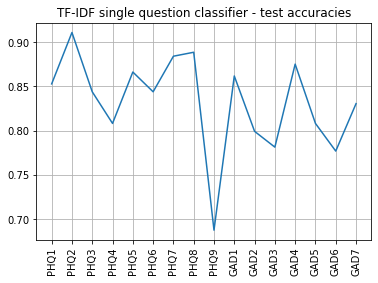

In [98]:
plt.plot(test_accuracies)
plt.xticks(np.arange(16), rotation=90, labels=X_h.columns)
plt.grid()
plt.title("TF-IDF single question classifier - test accuracies")
plt.show()

## Reconstruction

In this section, we will reconstruct the honest answers from the faked dataset. For this aim, we first apply the trivial method as our benchmark; then, depending on our outputs which are continuous numbers, we apply different appropriate machine learning models to see which one fits our model the best. The models we have applied are as follows:


- Trivial strategy (Benchmark) 
- Denoising AutoEncoder
- Neural Networks
- Multi-Output Regressors: 
   - - Linear Regression
   -- KNN Regressor
   -- DecisionTree Regressor
   -- Direct SVR
   -- Chained SVR
   -- Chained XGboost


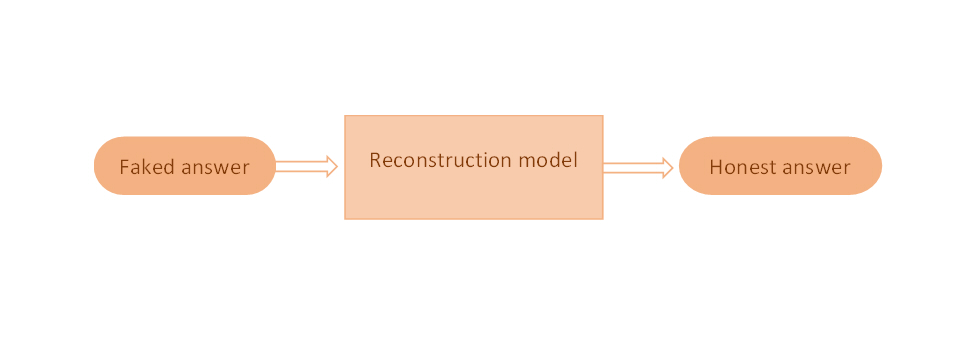

### Benchmark
-	Compute the average of difference between faked and honest
-	For each subject: Faked response – computed average 
-	Compare this number with real honest response of this person
-	We calculate accuracy

In [ ]:
# for each question average among all people
mean_resp = np.subtract(X_d, X_h).mean()
pred = round(X_d - mean_resp)

*In the following plot, you can see the trend of the mean in honest responses and our reconstructed answers from the trivial method and their closeness. As you see, these two plots also have a relatively high standard deviation, which a bit overlaps.*

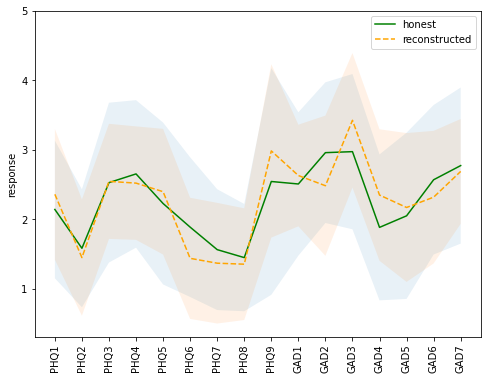

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(X_h.columns, X_h.mean(), color = 'green', label = 'honest')
plt.plot(X_h.columns, pred.mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), X_h.mean()-X_h.std(), X_h.mean()+X_h.std(),alpha=.1)
plt.fill_between(range(16), pred.mean()-pred.std(), pred.mean()+pred.std(),alpha=.1)
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
#plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

#### **Metrics**
Here we define our metrics. Our metrics are '**Accuracy**' and '**MSE**.' First, we define the accuracy, which computes the percentage of truly reconstructed answers, the 'accuracy' function computes accuracy for each 16 questions, and 'acc_overall' as the name indicates, computes the overall accuracy. We also define the 'mse' function for the trivial model but for the rest of the models, we use the built-in functions in the models to compute 'mse.'

In [ ]:
def accuracy(y, y_pred):
  y = np.array(y)
  y_pred = np.array(y_pred)
  m = np.round(1/len(y) * sum(y==y_pred), 2)
  return m

In [ ]:
def acc_overall(y, y_pred):
  y = np.array(y)
  y_pred = np.array(y_pred)
  acc = y_pred == y
  m = np.sum(acc) / (len(X_h.columns) * len(y))
  return m

In [ ]:
def mse(y,yhat):
  y = np.array(y)
  yhat = np.array(yhat)
  acc = ((y - yhat)**2).sum()
  m = acc / (len(X_h.columns)*len(X_h))
  return m

In [ ]:
def msetest(y,yhat):
  y = np.array(y)
  yhat = np.array(yhat)
  acc = ((y - yhat)**2).sum()
  m = acc / ((Xh_test.shape[0])*(Xh_test.shape[1]))
  return m

In [ ]:
# mean squared error
#we name the mse of benchmark msebench
msebench = mse(X_h, pred)
msebench

2.1537343470483004

In [ ]:
# accuracy for each question
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(X_h, pred)[i])

PHQ1 :  0.28
PHQ2 :  0.31
PHQ3 :  0.26
PHQ4 :  0.32
PHQ5 :  0.22
PHQ6 :  0.31
PHQ7 :  0.32
PHQ8 :  0.35
PHQ9 :  0.15
GAD1 :  0.3
GAD2 :  0.27
GAD3 :  0.26
GAD4 :  0.18
GAD5 :  0.17
GAD6 :  0.28
GAD7 :  0.3


In [ ]:
# overall accuracy

accbench = acc_overall(X_h, pred)
print("Overall accuracy with trivial strategy: ", accbench)

Overall accuracy with trivial strategy:  0.2662119856887299


*In this plot, you can see the accuracy of each question compared to the overall accuracy. As shown, the accuracy of each question is more or less around %27.*

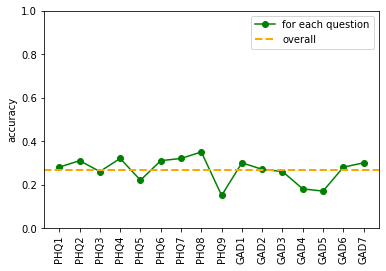

In [ ]:
plt.plot(X_h.columns, accuracy(X_h, pred), color = 'green', label='for each question', marker = 'o')
plt.axhline(y = acc_overall(X_h, pred), linewidth=2, color='orange', label = 'overall', linestyle = 'dashed')
plt.legend()
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.ylabel('accuracy')
plt.show()

### 1. Denoiser Autoeconder

*For the Denoising AutoEncoder, different configurations have been tried to achieve the best model; finally, a shallow autoencoder with linear activation function, ten neurons for encoded layer, and 'adam' optimizer seemed the best for our dataset; we also put our loss function the 'mse.'*

In [ ]:
input = tf.keras.layers.Input(shape=(16,))
encoded = tf.keras.layers.Dense(10, activation='linear')(input)

decoded = tf.keras.layers.Dense(16, activation='linear')(encoded)

autoencoder = tf.keras.models.Model(input, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

*Here we fit our model, we give the dishonest dataset as our input to the model and the honest dataset as the desired output.*

In [ ]:
history = autoencoder.fit(Xd_train, Xh_train, epochs=100, batch_size=16, shuffle=True, validation_data=(Xd_val, Xh_val))

Epoch 1/100
21/21 [==============================] - 1s 11ms/step - loss: 26.5655 - val_loss: 19.4439
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 14.9236 - val_loss: 11.2570
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 8.7094 - val_loss: 6.6625
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 5.1732 - val_loss: 4.0678
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 3.2453 - val_loss: 2.7283
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 2.2899 - val_loss: 2.0866
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 1.8547 - val_loss: 1.8099
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 1.6825 - val_loss: 1.7006
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 1.6230 - val_loss: 1.6613
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 1.5999 - val_loss: 1.6403
Epoc

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

4/4 - 0s - loss: 1.2670 - 87ms/epoch - 22ms/step
test mse: 1.26702


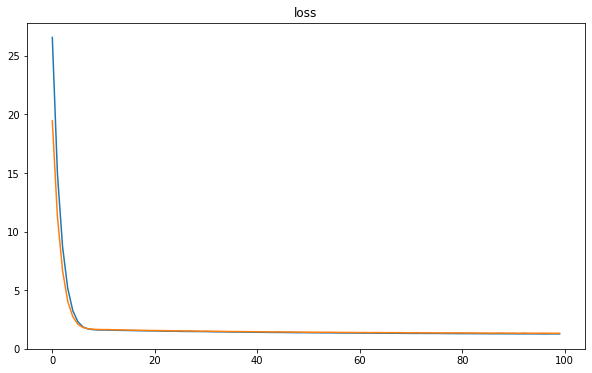

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(Xd_test, Xh_test, verbose=2)
print("test mse: %.5f" % (scores))

*From now on, we assign a name to each of our models, their 'MSE' and 'Accuracy' according to the order in which we have applied them. Here the Denoising AutoEncoder counts as our first model so we dedicate the names of its model,mse and, accuracy with suffix 1, and we do the same for the rest of the models.*

In [ ]:
mse1 = scores
mse1

1.267020583152771

In [ ]:
#predicting honest answers
model1 = np.round(autoencoder.predict(Xd_test))

*Since the output of the Denoising autoencoder is a continuous number, we have to round them to obtain answers compatible with our questionnaire, which is a range of numbers from one to five. While rounding numbers, we saw that a few of them round to zero and six, which are not in the possible answers of the questionnaire. We substitute these outcomes with one and six, which are the most probable numbers for these outcomes.*

*We also will do the same procedure for the following models.*

In [ ]:
model1[model1==0] = 1
model1[model1==6] = 5

In [ ]:
#Predicted answers
model1

array([[2., 1., 3., ..., 2., 3., 3.],
       [2., 1., 2., ..., 2., 1., 3.],
       [3., 1., 2., ..., 1., 2., 3.],
       ...,
       [2., 1., 3., ..., 2., 3., 3.],
       [2., 2., 3., ..., 2., 3., 3.],
       [2., 2., 3., ..., 2., 3., 2.]], dtype=float32)

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model1)[i])

#round((decoded_resp == Xh_test).sum() / len(Xd_test), 2)

accuracy for each question:
PHQ1 :  0.39
PHQ2 :  0.41
PHQ3 :  0.28
PHQ4 :  0.37
PHQ5 :  0.21
PHQ6 :  0.35
PHQ7 :  0.31
PHQ8 :  0.4
PHQ9 :  0.09
GAD1 :  0.33
GAD2 :  0.29
GAD3 :  0.26
GAD4 :  0.28
GAD5 :  0.28
GAD6 :  0.27
GAD7 :  0.29


In [ ]:
# overall accuracy
print("Overall accuracy with denoiser autoencoder: ", acc_overall(Xh_test, model1))

Overall accuracy with denoiser autoencoder:  0.29966517857142855


In [ ]:
# assigning a name to the overall accuracy
acc1 = acc_overall(Xh_test, model1)
acc1

0.29966517857142855

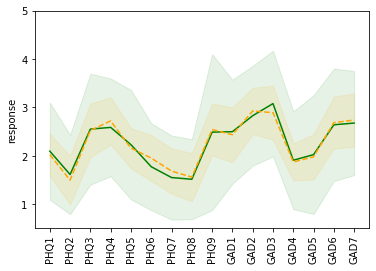

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from DAE
#plt.figure(figsize=(8,6))
plt.plot(Xh_train.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_train.columns, (pd.DataFrame(model1)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1,color = 'green')
plt.fill_between(range(16), (pd.DataFrame(model1)).mean()-(pd.DataFrame(model1)).std(), (pd.DataFrame(model1)).mean()+(pd.DataFrame(model1)).std(),alpha=.1,color = 'orange')
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.ylabel('response')
plt.show()

### 2. Neural Network

*For the neural network, we tried different layers and activation functions; finally, a shallow neural network gave us a better result in terms of accuracy. Here we apply a one-layer neural network with 'relu' activation function and, 'adam' optimizer.*

In [ ]:
# define the model
model = Sequential()
model.add(Dense(20, input_dim=16, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(16))
model.compile(loss='mse', optimizer='adam')

In [ ]:
# fit model
model.fit(Xd_train, Xh_train, verbose=0, epochs=100)

In [ ]:
#predicting the honest answers and rounding them
model2 = (model.predict(Xd_test)).round()
# summarize prediction
model2

array([[3., 2., 2., ..., 2., 2., 2.],
       [2., 2., 3., ..., 4., 4., 3.],
       [4., 2., 2., ..., 3., 2., 3.],
       ...,
       [2., 2., 2., ..., 2., 2., 3.],
       [2., 2., 3., ..., 2., 3., 3.],
       [2., 1., 3., ..., 2., 3., 3.]], dtype=float32)

In [ ]:
#substitute possible 0 and 6 outputs with 1 and 5
model2[model2[:] == 0] = 1
model2[model2[:] == 6] = 5

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model2)[i])

accuracy for each question:
PHQ1 :  0.37
PHQ2 :  0.37
PHQ3 :  0.29
PHQ4 :  0.44
PHQ5 :  0.31
PHQ6 :  0.34
PHQ7 :  0.39
PHQ8 :  0.45
PHQ9 :  0.15
GAD1 :  0.28
GAD2 :  0.37
GAD3 :  0.26
GAD4 :  0.28
GAD5 :  0.27
GAD6 :  0.34
GAD7 :  0.31


In [ ]:
# overall accuracy
acc2 = acc_overall(Xh_test, model2)
print("Overall accuracy with neural network: ", acc2)

Overall accuracy with neural network:  0.32533482142857145


In [ ]:
#neural net mse
mse2 = model.evaluate(Xd_test, Xh_test, verbose=2)
print("test mse: %.5f" % (mse2))

4/4 - 0s - loss: 1.3644 - 83ms/epoch - 21ms/step
test mse: 1.36440


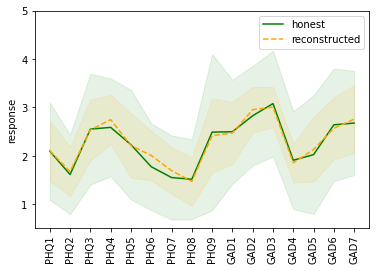

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from neural networks
#plt.figure(figsize=(8,6))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_test.columns, (pd.DataFrame(model2)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1,color = 'green')
plt.fill_between(range(16), (pd.DataFrame(model2)).mean()-(pd.DataFrame(model2)).std(), (pd.DataFrame(model2)).mean()+(pd.DataFrame(model2)).std(),alpha=.1,color = 'orange')
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.ylabel('response')
plt.show()

###Multi-Output Regressors
In this project, we face the problem of predicting multiple numerical outputs; therefore, we can apply multioutput regressors as a reconstruction model for our data. In this section, we apply three different regressors that inherently support multioutput problems. The models that we apply in this part are as below:
 - Linear Regression
 -  K-nearest Neighbor Regressor
 -  Decision Tree Regressor.

For the evaluation of 'mse' of the mentioned models, we use 10-fold cross-validation to have a more reliable and unbiased assessment of our models.

#### 3. Multi-Output Linear Regression

In [ ]:
# define model
model = LinearRegression()
# fit model
model.fit(Xd_train, Xh_train)

LinearRegression()

In [ ]:
# make a prediction
model3 = model.predict(Xd_test)
# summarize prediction
print(model3)

[[1.98046518 1.49322969 2.50953093 ... 2.37254786 2.60393068 2.75898893]
 [2.32091684 1.72107577 2.90879216 ... 1.73100695 1.96090603 2.41090423]
 [2.76284314 1.34329266 2.12817454 ... 1.08611013 2.04113771 3.63222651]
 ...
 [2.28967831 1.39855838 2.25122439 ... 1.77693947 2.38806799 2.91755431]
 [2.25061759 1.45344655 2.29862509 ... 1.80671901 2.48856925 2.86423273]
 [1.95463115 1.5748713  2.63202721 ... 2.5222258  2.74454695 2.37487773]]


In [ ]:
#prediction with rounding them
model3 = (model.predict(Xd_test)).round()
# output
model3

array([[2., 1., 3., ..., 2., 3., 3.],
       [2., 2., 3., ..., 2., 2., 2.],
       [3., 1., 2., ..., 1., 2., 4.],
       ...,
       [2., 1., 2., ..., 2., 2., 3.],
       [2., 1., 2., ..., 2., 2., 3.],
       [2., 2., 3., ..., 3., 3., 2.]])

In [ ]:
#substitute possible 0 and 6 outputs with 1 and 5
model3[model3[:] == 0] = 1
model3[model3[:] == 6] = 5

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model3)[i])

accuracy for each question:
PHQ1 :  0.39
PHQ2 :  0.5
PHQ3 :  0.32
PHQ4 :  0.41
PHQ5 :  0.29
PHQ6 :  0.37
PHQ7 :  0.32
PHQ8 :  0.52
PHQ9 :  0.1
GAD1 :  0.3
GAD2 :  0.32
GAD3 :  0.26
GAD4 :  0.38
GAD5 :  0.28
GAD6 :  0.27
GAD7 :  0.29


In [ ]:
# overall accuracy
acc3 = acc_overall(Xh_test, model3)
print("Overall accuracy with Multi_output linear Regression: ", acc3)

Overall accuracy with Multi_output linear Regression:  0.33203125


In [ ]:
#Evaluation of model using using 10-fold cross validation
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
result = cross_val_score(model, Xd_test, Xh_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(result)
# calculate mean of scores for all folds
mse = n_scores.mean()
# calculate standard deviation
stdAccuracy = result.std()
# summarize performance
print("Mean square Error: %.3f, Standard Deviation : %.3f" % (mse, stdAccuracy))

Mean square Error: 1.421, Standard Deviation : 0.194


In [ ]:
mse3 = mse
mse3

1.4211605718453504

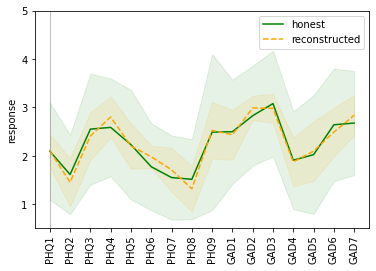

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from Linear Regression
#plt.figure(figsize=(8,6))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_test.columns, (pd.DataFrame(model3)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1, color = 'green')
plt.fill_between(range(16), (pd.DataFrame(model3)).mean()-(pd.DataFrame(model3)).std(), (pd.DataFrame(model3)).mean()+(pd.DataFrame(model3)).std(),alpha=.1, color = 'orange')
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

#### 4. K-nearest Neighbor Regressor

In [ ]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(Xd_train, Xh_train)

KNeighborsRegressor()

In [ ]:
# make a prediction
model4 = model.predict(Xd_test)
# summarize prediction
print(model4)

[[2.8 1.6 3.4 ... 2.  3.2 3.2]
 [2.  1.6 3.  ... 2.4 2.6 2.4]
 [2.4 1.2 2.2 ... 1.  2.2 3. ]
 ...
 [2.2 1.4 2.4 ... 1.  2.6 2.6]
 [2.2 1.2 2.2 ... 1.4 2.2 2.6]
 [1.8 2.4 2.8 ... 3.  2.4 3. ]]


In [ ]:
#rounding predictions
model4 = model4.round()
# output
print(model4)

[[3. 2. 3. ... 2. 3. 3.]
 [2. 2. 3. ... 2. 3. 2.]
 [2. 1. 2. ... 1. 2. 3.]
 ...
 [2. 1. 2. ... 1. 3. 3.]
 [2. 1. 2. ... 1. 2. 3.]
 [2. 2. 3. ... 3. 2. 3.]]


In [ ]:
#substitute possible 0 and 6 outputs with 1 and 5
model4[model4[:] == 0] = 1
model4[model4[:] == 6] = 5

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model4)[i])

accuracy for each question:
PHQ1 :  0.42
PHQ2 :  0.43
PHQ3 :  0.27
PHQ4 :  0.39
PHQ5 :  0.23
PHQ6 :  0.38
PHQ7 :  0.4
PHQ8 :  0.49
PHQ9 :  0.13
GAD1 :  0.29
GAD2 :  0.37
GAD3 :  0.31
GAD4 :  0.3
GAD5 :  0.31
GAD6 :  0.26
GAD7 :  0.28


In [ ]:
# overall accuracy

acc4 = acc_overall(Xh_test, model4)
print("Overall accuracy with K-nearest Neighbor Regressor: ", acc4)

Overall accuracy with K-nearest Neighbor Regressor:  0.3286830357142857


In [ ]:
#Evaluation of model using using 10-fold cross validation
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
result = cross_val_score(model, Xd_test, Xh_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(result)
# calculate mean of scores for all folds
mse = n_scores.mean()
# calculate standard deviation
stdAccuracy = result.std()
# summarize performance
print("Mean square Error: %.3f, Standard Deviation : %.3f" % (mse, stdAccuracy))

Mean square Error: 1.346, Standard Deviation : 0.173


In [ ]:
mse4 = mse
mse4

1.3461517045454545

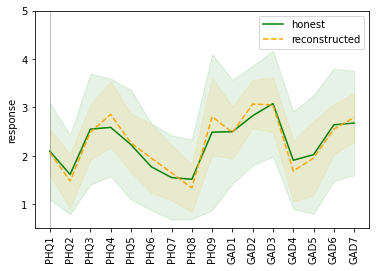

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from K-nearest Neighbor Regressor
#plt.figure(figsize=(8,6))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_test.columns, (pd.DataFrame(model4)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1, color = 'green')
plt.fill_between(range(16), (pd.DataFrame(model4)).mean()-(pd.DataFrame(model4)).std(), (pd.DataFrame(model4)).mean()+(pd.DataFrame(model4)).std(),alpha=.1, color = 'orange')
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

#### 5. Decision Tree Regressor

In [ ]:
# define model
model = DecisionTreeRegressor()
# fit model
model.fit(Xd_train, Xh_train)

DecisionTreeRegressor()

In [ ]:
# make a prediction
model5 = model.predict(Xd_test)
# summarize prediction
print(model5)

[[1.         1.         4.         ... 3.         4.         3.        ]
 [1.         1.         1.         ... 1.         2.         2.        ]
 [2.5        2.5        1.5        ... 2.         2.         3.5       ]
 ...
 [2.         1.         2.5        ... 1.         2.5        4.        ]
 [2.31428571 1.45714286 2.34285714 ... 1.74285714 2.4        2.68571429]
 [1.         4.         4.         ... 4.         4.         4.        ]]


In [ ]:
#rounding predictions
model5 = model5.round()
#output
model5

array([[1., 1., 4., ..., 3., 4., 3.],
       [1., 1., 1., ..., 1., 2., 2.],
       [2., 2., 2., ..., 2., 2., 4.],
       ...,
       [2., 1., 2., ..., 1., 2., 4.],
       [2., 1., 2., ..., 2., 2., 3.],
       [1., 4., 4., ..., 4., 4., 4.]])

In [ ]:
#substitute possible 0 and 6 outputs with 1 and 5
model5[model5[:] == 0] = 1
model5[model5[:] == 6] = 5

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model5)[i])

accuracy for each question:
PHQ1 :  0.38
PHQ2 :  0.42
PHQ3 :  0.24
PHQ4 :  0.29
PHQ5 :  0.27
PHQ6 :  0.36
PHQ7 :  0.37
PHQ8 :  0.54
PHQ9 :  0.21
GAD1 :  0.23
GAD2 :  0.29
GAD3 :  0.19
GAD4 :  0.34
GAD5 :  0.29
GAD6 :  0.28
GAD7 :  0.26


In [ ]:
# overall accuracy

acc5 = acc_overall(Xh_test, model5)
print("Overall accuracy with K-nearest Neighbor Regressor: ", acc5)

Overall accuracy with K-nearest Neighbor Regressor:  0.3080357142857143


In [ ]:
#Evaluation of model using using 10-fold cross validation
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
result = cross_val_score(model, Xd_test, Xh_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(result)
# calculate mean of scores for all folds
mse = n_scores.mean()
# calculate standard deviation
stdAccuracy = result.std()
# summarize performance
print("Mean square Error: %.3f, Standard Deviation : %.3f" % (mse, stdAccuracy))

Mean square Error: 2.139, Standard Deviation : 0.330


In [ ]:
mse5 = mse
mse5

2.1387210609717666

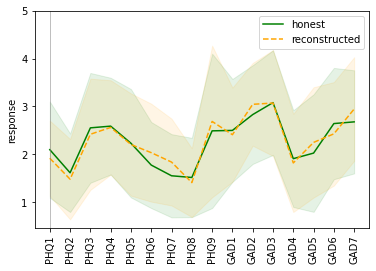

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from Decision Tree Regressor
#plt.figure(figsize=(8,6))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_test.columns, (pd.DataFrame(model5)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1, color = 'green')
plt.fill_between(range(16), (pd.DataFrame(model5)).mean()-(pd.DataFrame(model5)).std(), (pd.DataFrame(model5)).mean()+(pd.DataFrame(model5)).std(),alpha=.1, color = 'orange')
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

#### Wrapper Multioutput Regression
Not all regression algorithms support multioutput
regression.                           
One example is the support vector machine, although for regression, it is referred to as support vector regression, or SVR.    
In this situations we can split a multioutput regression problem into multiple single-output regression problems. There are two main approaches to implementing this technique:


1.   Direct Multioutput
2.   Chained Multioutput



*   The first approach involves developing a separate regression model for each output value to be predicted. We can think of this as a direct approach, as each target value is modeled directly.
*   The second approach is an extension of the first method except the models are organized into a chain. The prediction from the first model is taken as part of the input to the second model, and the process of output-to-input dependency repeats along the chain of models.

In this section we implement three wrapper Multioutput regressor:
 - SVR (Direct approach)
 - SVR (Chained approach)
 - XGboost (Chained approach)

#### 6. Direct Multi-Output Regression (SVR)

In [ ]:
# define base model
model = LinearSVR()
# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

In [ ]:
# fit the model on the dataset
wrapper.fit(Xd_train, Xh_train)
# make prediction
model6 = wrapper.predict(Xd_test)
# summarize the prediction
print('Predicted: %s' % model6)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Predicted: [[1.7512849  1.00027879 2.47853841 ... 2.6145324  2.55894847 2.74136459]
 [1.9740654  1.00002299 2.12846417 ... 0.95148633 1.81767378 1.88111378]
 [2.77894415 1.00035993 1.80163983 ... 1.24833482 1.58791217 3.11446592]
 ...
 [2.09707983 1.00041862 1.89570238 ... 1.74297027 2.38393504 2.87546458]
 [2.02302484 1.00042801 1.98303795 ... 1.79352669 2.47336782 2.79057981]
 [1.62132043 1.00024291 2.37858174 ... 2.41990398 2.86036292 2.25295151]]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
model6

array([[1.7512849 , 1.00027879, 2.47853841, ..., 2.6145324 , 2.55894847,
        2.74136459],
       [1.9740654 , 1.00002299, 2.12846417, ..., 0.95148633, 1.81767378,
        1.88111378],
       [2.77894415, 1.00035993, 1.80163983, ..., 1.24833482, 1.58791217,
        3.11446592],
       ...,
       [2.09707983, 1.00041862, 1.89570238, ..., 1.74297027, 2.38393504,
        2.87546458],
       [2.02302484, 1.00042801, 1.98303795, ..., 1.79352669, 2.47336782,
        2.79057981],
       [1.62132043, 1.00024291, 2.37858174, ..., 2.41990398, 2.86036292,
        2.25295151]])

In [ ]:
#rounding the prediction
model6 = model6.round()
model6

array([[2., 1., 2., ..., 3., 3., 3.],
       [2., 1., 2., ..., 1., 2., 2.],
       [3., 1., 2., ..., 1., 2., 3.],
       ...,
       [2., 1., 2., ..., 2., 2., 3.],
       [2., 1., 2., ..., 2., 2., 3.],
       [2., 1., 2., ..., 2., 3., 2.]])

In [ ]:
#substitute possible 0 and 6 outputs with 1 and 5
model6[model6[:] == 0] = 1
model6[model6[:] == 6] = 5

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model6)[i])

accuracy for each question:
PHQ1 :  0.41
PHQ2 :  0.56
PHQ3 :  0.3
PHQ4 :  0.4
PHQ5 :  0.23
PHQ6 :  0.42
PHQ7 :  0.63
PHQ8 :  0.64
PHQ9 :  0.25
GAD1 :  0.33
GAD2 :  0.32
GAD3 :  0.26
GAD4 :  0.41
GAD5 :  0.3
GAD6 :  0.26
GAD7 :  0.28


In [ ]:
# overall accuracy

acc6 = acc_overall(Xh_test, model6)
print("Overall accuracy with SVR regressor: ", acc6)

Overall accuracy with SVR regressor:  0.37611607142857145


In [ ]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
result = cross_val_score(wrapper, Xd_test, Xh_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(result)
# calculate mean of scores for all folds
mse = n_scores.mean()
# calculate standard deviation
stdAccuracy = result.std()
# summarize performance
print("Mean square Error: %.3f, Standard Deviation : %.3f" % (mse, stdAccuracy))

Mean square Error: 1.621, Standard Deviation : 0.260


In [ ]:
mse6 = mse
mse6

1.621350239242457

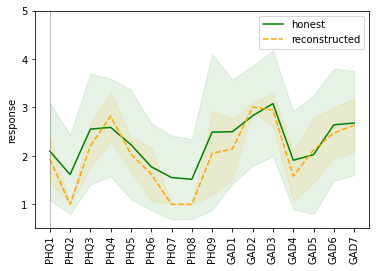

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from SVR Regressor (Direct approach)
#plt.figure(figsize=(8,6))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_test.columns, (pd.DataFrame(model6)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1, color = 'green')
plt.fill_between(range(16), pd.DataFrame(model6).mean()-pd.DataFrame(model6).std(), pd.DataFrame(model6).mean()+pd.DataFrame(model6).std(),alpha=.1, color = 'orange')
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

####7. Chained Multioutput Regression (SVR)

In [ ]:
# define base model
model = LinearSVR()
# define the chained multioutput wrapper model
wrapper = RegressorChain(model)

In [ ]:
# fit the model on the dataset
wrapper.fit(Xd_train, Xh_train)
# make prediction
model7 = wrapper.predict(Xd_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

In [ ]:
# summarize the prediction
print('Predicted: %s' % model7)

Predicted: [[2.00309733 1.29865715 2.28591617 ... 1.9600858  2.23111278 2.27344061]
 [2.13465194 1.22702413 2.41059279 ... 0.50153935 1.07693291 1.39148767]
 [2.98162845 1.27950233 1.88858353 ... 0.43327855 1.527038   3.18631978]
 ...
 [2.37927067 1.30419592 1.96025983 ... 1.33636476 1.94993252 2.38185436]
 [2.28850764 1.33536944 2.03358759 ... 1.38299464 1.92330705 2.30647985]
 [1.8631031  1.38965067 2.41775334 ... 2.21642018 2.11980779 1.77462929]]


In [ ]:
#rounding predictions
model7 = model7.round()
model7

array([[2., 1., 2., ..., 2., 2., 2.],
       [2., 1., 2., ..., 1., 1., 1.],
       [3., 1., 2., ..., 0., 2., 3.],
       ...,
       [2., 1., 2., ..., 1., 2., 2.],
       [2., 1., 2., ..., 1., 2., 2.],
       [2., 1., 2., ..., 2., 2., 2.]])

In [ ]:
#substitute possible 0 and 6 outputs with 1 and 5
model7[model7[:] == 0] = 1
model7[model7[:] == 6] = 5

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model7)[i])

accuracy for each question:
PHQ1 :  0.36
PHQ2 :  0.56
PHQ3 :  0.3
PHQ4 :  0.38
PHQ5 :  0.29
PHQ6 :  0.46
PHQ7 :  0.63
PHQ8 :  0.64
PHQ9 :  0.37
GAD1 :  0.39
GAD2 :  0.31
GAD3 :  0.24
GAD4 :  0.38
GAD5 :  0.44
GAD6 :  0.26
GAD7 :  0.32


In [ ]:
# overall accuracy

acc7 = acc_overall(Xh_test, model7)
print("Overall accuracy with SVR regressor: ", acc7)

Overall accuracy with SVR regressor:  0.39676339285714285


In [ ]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
result = cross_val_score(wrapper, Xd_test, Xh_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(result)
# calculate mean of scores for all folds
mse = n_scores.mean()
# calculate standard deviation
stdAccuracy = result.std()
# summarize performance
print("Mean square Error: %.3f, Standard Deviation : %.3f" % (mse, stdAccuracy))

Mean square Error: 1.620, Standard Deviation : 0.274


In [ ]:
mse7 = mse
mse7

1.619887078663914

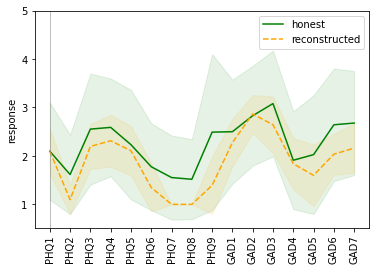

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from SVR Regressor (Chained approach)
#plt.figure(figsize=(8,6))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_test.columns, (pd.DataFrame(model7)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1, color = 'green')
plt.fill_between(range(16), pd.DataFrame(model7).mean()-pd.DataFrame(model7).std(), pd.DataFrame(model7).mean()+pd.DataFrame(model7).std(),alpha=.1, color = 'orange' )
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

#### 8 . Chained Multioutput Regression (xGboost)

In [ ]:
# define base model
model = XGBRegressor(objective='reg:squarederror')
# define the chained multioutput wrapper model
wrapper = RegressorChain(model)

In [ ]:
# fit the model on the dataset
wrapper.fit(Xd_train, Xh_train)
# make prediction
model8 = wrapper.predict(Xd_test)
# summarize the prediction
print('Predicted: %s' % model8)

Predicted: [[2.28349519 1.58959877 2.39195395 ... 1.7027303  2.99142408 3.14990425]
 [1.57677507 1.61503482 2.66864705 ... 3.28746557 2.58683395 2.84433699]
 [2.36830497 1.30532551 1.12194955 ... 1.29416776 1.76831961 2.8647964 ]
 ...
 [2.36595201 1.30479789 1.98869598 ... 1.2172718  1.98641896 2.69054651]
 [2.20955753 1.36320877 1.65910661 ... 1.2172718  2.02022338 2.6724    ]
 [1.87006056 1.72642207 2.2049489  ... 2.42620659 2.75727963 2.80979419]]


In [ ]:
#rounding prediction
model8 = model8.round()
model8

array([[2., 2., 2., ..., 2., 3., 3.],
       [2., 2., 3., ..., 3., 3., 3.],
       [2., 1., 1., ..., 1., 2., 3.],
       ...,
       [2., 1., 2., ..., 1., 2., 3.],
       [2., 1., 2., ..., 1., 2., 3.],
       [2., 2., 2., ..., 2., 3., 3.]])

In [ ]:
#substitute possible 0 and 6 outputs with 1 and 5
model8[model8[:] == 0] = 1
model8[model8[:] == 6] = 5

In [ ]:
# accuracy for each question

print('accuracy for each question:')
for i in range(len(X_h.columns)):
  print(X_h.columns[i], ": ", accuracy(Xh_test, model8)[i])

accuracy for each question:
PHQ1 :  0.42
PHQ2 :  0.44
PHQ3 :  0.22
PHQ4 :  0.38
PHQ5 :  0.26
PHQ6 :  0.33
PHQ7 :  0.51
PHQ8 :  0.46
PHQ9 :  0.11
GAD1 :  0.29
GAD2 :  0.31
GAD3 :  0.29
GAD4 :  0.29
GAD5 :  0.43
GAD6 :  0.27
GAD7 :  0.26


In [ ]:
# overall accuracy

acc8 = acc_overall(Xh_test, model8)
print("Overall accuracy with xGboost regressor: ", acc8)

Overall accuracy with xGboost regressor:  0.32979910714285715


In [ ]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, random_state=1)
# evaluate the model and collect the scores
result = cross_val_score(wrapper, Xd_test, Xh_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(result)
# calculate mean of scores for all folds
mse = n_scores.mean()
# calculate standard deviation
stdAccuracy = result.std()
# summarize performance
print("Mean square Error: %.3f, Standard Deviation : %.3f" % (mse, stdAccuracy))

Mean square Error: 1.534, Standard Deviation : 0.194


In [ ]:
mse8 = mse
mse8

1.534103250765018

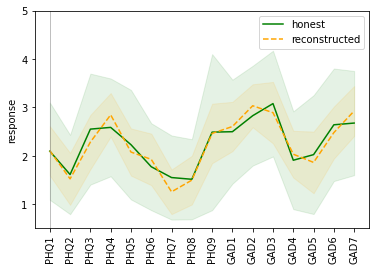

In [ ]:
#plot of the mean of the answers in honest dataset and the reconstructed dataset from XGboost Regressor (Chained approach)
#plt.figure(figsize=(8,6))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'green', label = 'honest')
plt.plot(Xh_test.columns, (pd.DataFrame(model8)).mean(), color = 'orange', label = 'reconstructed', linestyle = 'dashed')
plt.fill_between(range(16), Xh_test.mean()-Xh_test.std(), Xh_test.mean()+Xh_test.std(),alpha=.1,color = 'green')
plt.fill_between(range(16), pd.DataFrame(model8).mean()-pd.DataFrame(model8).std(), pd.DataFrame(model8).mean()+pd.DataFrame(model8).std(),alpha=.1, color = 'orange')
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(rotation=90)
plt.axvline(linewidth=0.5, color='gray')
plt.ylabel('response')
plt.show()

###Model Comparison

In this part, we will visualize the results of our models using boxplots to see which model performed better in terms of 'Accuracy' and 'MSE.'

In [ ]:
ModelsName = ['Benchmark','Denoiser Aoutoencoder','Neural Network','Linear Regression','KNN Regressor','Decision Tree Regressor','Direct SVR','Chained SVR','Chained XGboost']

Accuracy = [accbench,acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8]

In [ ]:
modeldata = {"columns":ModelsName ,
        "Accuracy": Accuracy}
models = pd.DataFrame(modeldata, columns=['columns', 'Accuracy'])
models= models.sort_values(by=['Accuracy'])

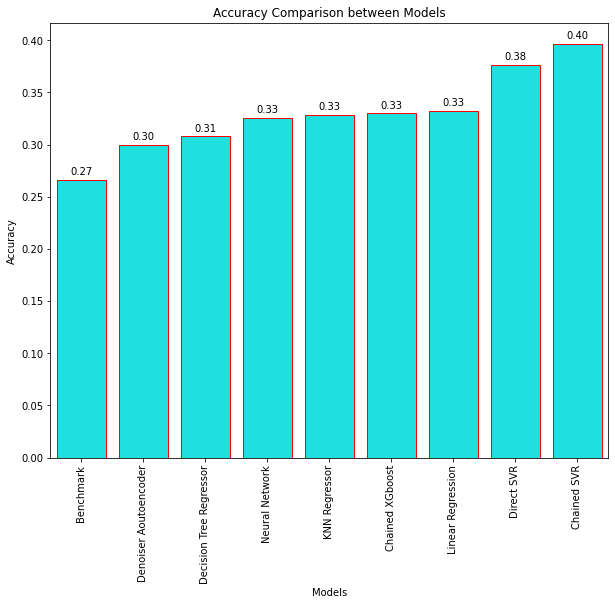

In [ ]:
plt.figure(figsize=(10,8))
plots = sns.barplot(x="columns", y="Accuracy", data=models,color='cyan', edgecolor = 'red')
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=10)
plt.xticks(rotation=90)
plt.ylabel("Accuracy", size=10)
plt.title("Accuracy Comparison between Models")
plt.show()


In [ ]:
allmse = [msebench,mse1,mse2,mse3,mse4,mse5,mse6,mse7,mse8]
msedic = {"columns":ModelsName ,
        "MSE": allmse}
msedata = pd.DataFrame(msedic, columns=['columns', 'MSE'])
msedata = msedata.sort_values(by=['MSE'], ascending = False)

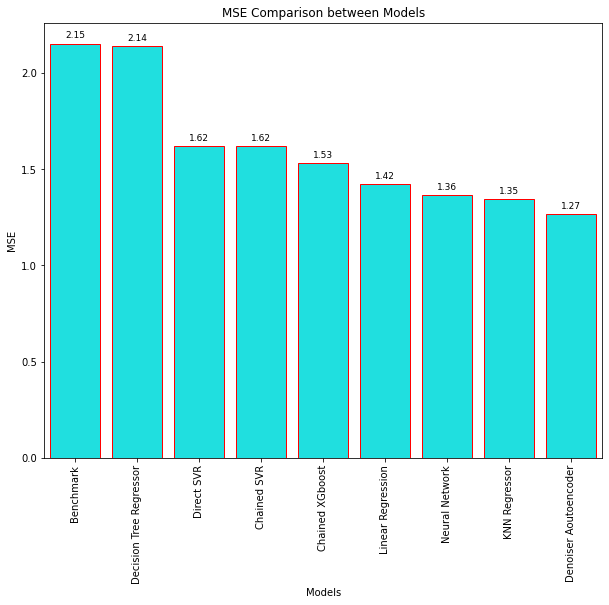

In [ ]:
plt.figure(figsize=(10,8))
plots = sns.barplot(x="columns", y="MSE", data=msedata ,color='cyan', edgecolor = 'red')
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=10)
plt.xticks(rotation=90)
plt.ylabel("MSE", size=10)
plt.title("MSE Comparison between Models")
plt.show()

- Concerning these two plots, we can see that chained SVR has a better performance in predicting the exact honest answer(Accuracy), but Denoising AutoEncoder has a better performance in terms of MSE.
- In the following, we analyze the outputs of these two models to see their behavior more precisely.

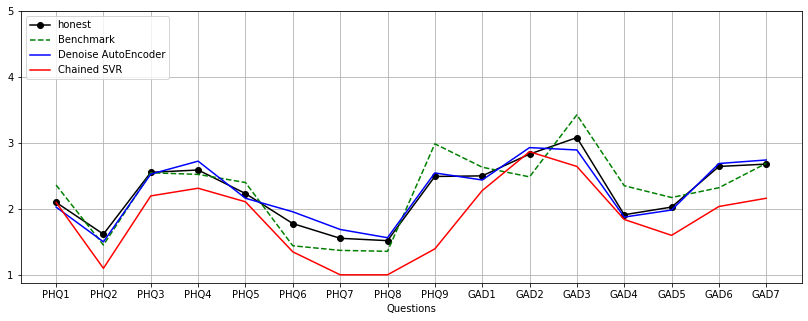

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(Xh_test.columns, Xh_test.mean(), color = 'black', label = 'honest',  marker='o')
plt.plot(Xh_test.columns, (pd.DataFrame(pred)).mean(), color = 'green', label = 'Benchmark', linestyle = 'dashed')
plt.plot(Xh_test.columns, (pd.DataFrame(model1)).mean(), color = 'blue', label = 'Denoise AutoEncoder')
#plt.plot(Xh_test.columns, (pd.DataFrame(model2)).mean(), color = 'blue', label = 'Neural Network')
#plt.plot(Xh_test.columns, (pd.DataFrame(model3)).mean(), color = 'yellow', label = 'Linear Regression')
#plt.plot(Xh_test.columns, (pd.DataFrame(model4)).mean(), color = 'yellow', label = 'Knn Regressor')
#plt.plot(Xh_test.columns, (pd.DataFrame(model5)).mean(), color = 'brown', label = 'Decision Tree Regressor')
#plt.plot(Xh_test.columns, (pd.DataFrame(model6)).mean(), color = 'red', label = 'SVR')
plt.plot(Xh_test.columns, (pd.DataFrame(model7)).mean(), color = 'red', label = 'Chained SVR')
#plt.plot(Xh_test.columns, (pd.DataFrame(model8)).mean(), color = 'violet', label = 'Chained XGboost')
plt.legend(loc='upper left')
plt.yticks([1, 2, 3, 4, 5])
#plt.xticks(rotation=90)
plt.xlabel('Questions')
plt.grid(which='major')
plt.show()

- Here we can see that the DenoisingAE catches the trend of the mean in honest answers better. The SVR model doesn't seem so well-performing in this plot, but in the following plots, we can see that SVR has a much better performance in predicting every single answer.

- First, we take a look at the difference between the faked and honest answers to have an overview of which question might be more tricky for our models to predict.

In [ ]:
diff = np.subtract(X_d, X_h )

No handles with labels found to put in legend.


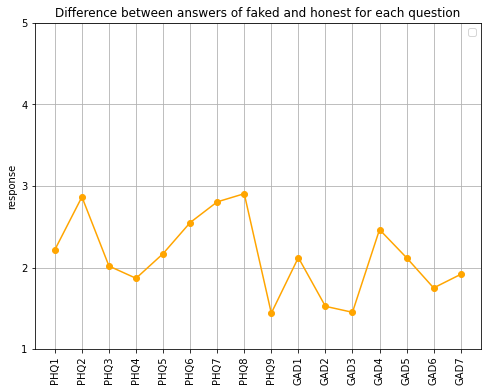

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(diff.mean(), color = 'orange', marker = 'o')
plt.legend()
plt.yticks([1, 2, 3, 4, 5])
plt.xticks(Xh_test.columns, rotation=90)
plt.ylabel('response')
plt.title("Difference between answers of faked and honest for each question")
plt.grid(which='major')
plt.show()

- As it is depicted in this plot, questions PHQ9, GAD2 and GAD3 are faked less than other questions, so reconstructing these questions might be harder. Also, it is nice to mention that in question PHQ2, we have a high difference in honest and faked answers. This question was the most critical question for our classification methods which we saw in previous parts, so this might be one reason why this question was important in classification.
- In the, following we analyze the accuracy of every single question in our two best performing models compared to Benchmark.

In [ ]:
accbench = (accuracy(X_h, pred)).tolist()
databench = {"columns":X_h.columns ,
        "Accuracy": accbench}
dfbench = pd.DataFrame(databench, columns=['columns', 'Accuracy'])

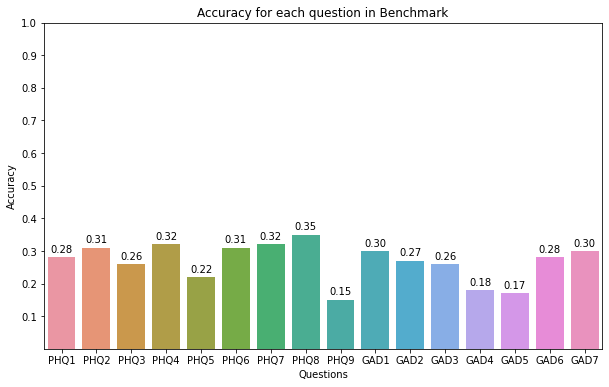

In [ ]:
plt.figure(figsize=(10,6))
plots = sns.barplot(x="columns", y="Accuracy", data=dfbench)
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Questions", size=10)
plt.ylabel("Accuracy", size=10)
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title("Accuracy for each question in Benchmark")
plt.show()

As you see in the above plot, the benchmark accuracy in most of our questions is around %30. Also, the question 'PHQ9', which we mentioned in the previous part as a question hard to reconstruct, has the least accuracy here.

In [ ]:
acc1 = (accuracy(Xh_test, model1)).tolist()
data1 = {"columns":X_h.columns ,
        "Accuracy": acc1}
df1 = pd.DataFrame(data1, columns=['columns', 'Accuracy'])

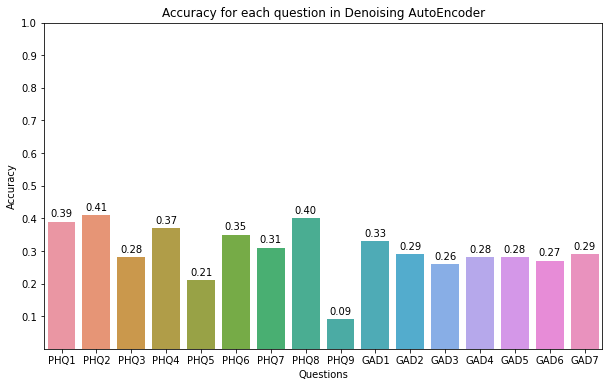

In [ ]:
plt.figure(figsize=(10,6))
plots = sns.barplot(x="columns", y="Accuracy", data=df1)
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Questions", size=10)
plt.ylabel("Accuracy", size=10)
plt.title("Accuracy for each question in Denoising AutoEncoder")
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.show()

For the denoising AoutoEncoder, we see a slightly better performance in single question accuracy. However, the question 'PHQ9' has decreased, but other questions are better reconstructed, and we have multiple questions with around %40 accuracy.

In [ ]:
acc7 = (accuracy(Xh_test, model7)).tolist()
data7 = {"columns":X_h.columns ,
        "Accuracy": acc7}
df7 = pd.DataFrame(data7, columns=['columns', 'Accuracy'])

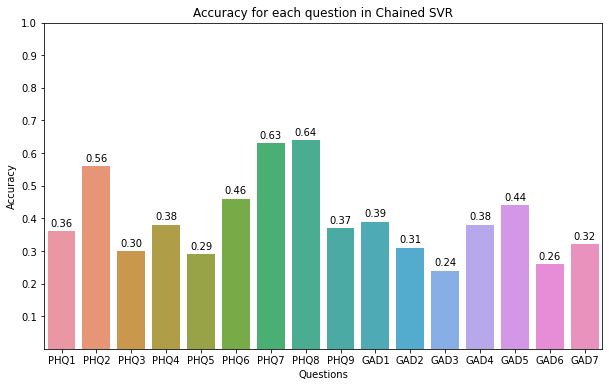

In [ ]:
plt.figure(figsize=(10,6))
plots = sns.barplot(x="columns", y="Accuracy", data= df7)
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Questions", size=10)
plt.ylabel("Accuracy", size=10)
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title("Accuracy for each question in Chained SVR")
plt.show()

In chained SVR, we see a very good improvement compared to denoising AutoEncoder; we have three questions reconstructed with more than %50 accuracies; also, the questions with lower accuracy like 'PHQ9' is so much better reconstructed with this model.

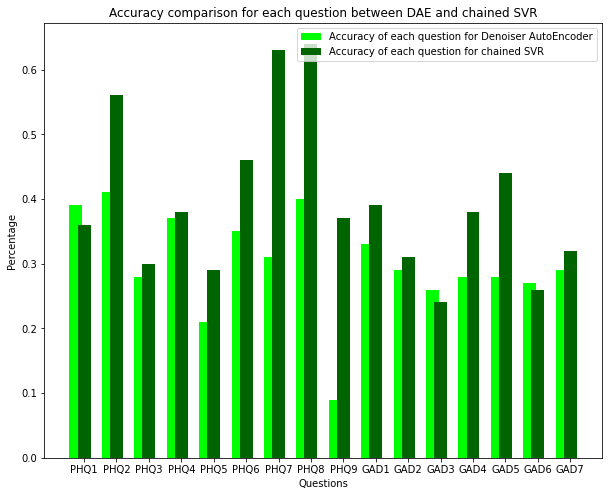

In [ ]:
plt.figure(figsize=[10, 8])
acc1
acc7
X = np.arange(len(acc1))

plt.bar(X, acc1, color = 'lime', width = 0.4)
plt.bar(X + 0.25, acc7, color = 'darkgreen', width = 0.4)

plt.legend(['Accuracy of each question for Denoiser AutoEncoder', 'Accuracy of each question for chained SVR'])

plt.xticks([i + 0.25 for i in range(16)], X_h.columns)

plt.title("Accuracy comparison for each question between DAE and chained SVR")
plt.xlabel('Questions')
plt.ylabel('Percentage')

plt.show()

As we see, the accuracy of each question is higher in most of the questions with the SVR model; the DenoiserAE is better in 3 questions but not with a significant difference.

In the following, we investigate the distribution overlaps for each qusetion in the honest dataset compared with benchmark,DenoiserAE and SVR.

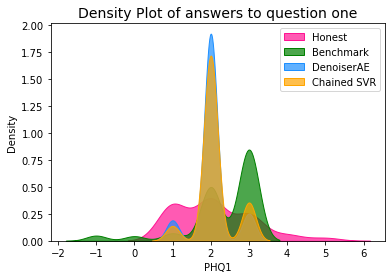

In [ ]:
#plt.figure(figsize=(7,5))
sns.kdeplot(Xh_test['PHQ1'], shade=True, color="deeppink", label="Honest", alpha=.7)
sns.kdeplot(pred['PHQ1'], shade=True, color="g", label="Benchmark", alpha=.7)
sns.kdeplot(pd.DataFrame(model1)[0],shade=True, color="dodgerblue", label="DenoiserAE", alpha=.7)
sns.kdeplot(pd.DataFrame(model7)[0], shade=True, color="orange", label="Chained SVR", alpha=.7)

plt.title('Density Plot of answers to question one', fontsize=14)
plt.legend()
plt.show()

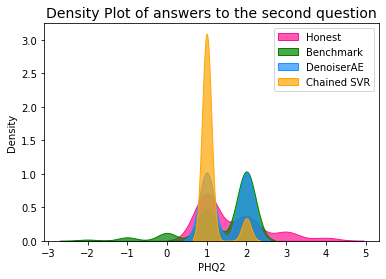

In [ ]:
#plt.figure(figsize=(7,5))
sns.kdeplot(Xh_test['PHQ2'], shade=True, color="deeppink", label="Honest", alpha=.7)
sns.kdeplot(pred['PHQ2'], shade=True, color="g", label="Benchmark", alpha=.7)
sns.kdeplot(pd.DataFrame(model1)[1],shade=True, color="dodgerblue", label="DenoiserAE", alpha=.7)
sns.kdeplot(pd.DataFrame(model7)[1], shade=True, color="orange", label="Chained SVR", alpha=.7)

plt.title('Density Plot of answers to the second question', fontsize=14)
plt.legend()
plt.show()

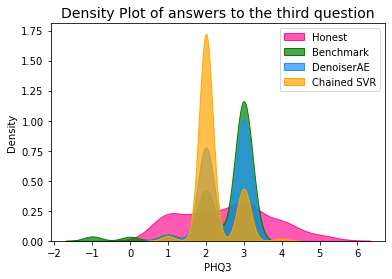

In [ ]:
#plt.figure(figsize=(7,5))
sns.kdeplot(Xh_test['PHQ3'], shade=True, color="deeppink", label="Honest", alpha=.7)
sns.kdeplot(pred['PHQ3'], shade=True, color="g", label="Benchmark", alpha=.7)
sns.kdeplot(pd.DataFrame(model1)[2],shade=True, color="dodgerblue", label="DenoiserAE", alpha=.7)
sns.kdeplot(pd.DataFrame(model7)[2], shade=True, color="orange", label="Chained SVR", alpha=.7)

plt.title('Density Plot of answers to the third question', fontsize=14)
plt.legend()
plt.show()

In all these plots, what is significant about SVR, which makes it our best model, is that it truly catches the most common answers in the honest distribution. For example, in the first plot, which is the density function for the answers in the first question, we can see that 1,2 and 3 were the most common answers in the honest distribution and 2 has the most density, the SVR distribution exactly has the higher density in 1,2 and 3 with 3 as the pick. Also, we see that benchmark is so variant and does not catch the most common answers, and DAE is mostly too biased in one response.

- Conclusion:

As we analyzed the models in the previous part, we conclude that the Chained SVR is our best model for reconstructing the honest responses from the faked dataset with the overall accuracy of %40 and %13 improvement with respect to our benchmark.